<div style="background-color:#00bfff; padding:12px; border-radius:8px; color:white; font-size:18px; font-weight:bold;">
🖼️ Intel Image Classification – CNN (ResNet18) Eğitimi
</div>

<div style="background-color:#E6F2FA; padding:12px; border-radius:8px; font-size:16px;">

<b>📘 Veri Seti Hakkında Bilgiler:</b><br><br>

Bu veri seti, dünyanın farklı bölgelerinden çekilmiş doğal sahne görüntülerini içermektedir.  
Veri seti, Intel tarafından hazırlanmış ve ilk kez <b>Analytics Vidhya Image Classification Challenge</b> kapsamında yayınlanmıştır.<br><br>

Toplamda yaklaşık <b>25.000</b> adet <b>150x150 piksel</b> boyutunda renkli görüntü bulunmaktadır.  
Veri, <b>Train (14k)</b>, <b>Test (3k)</b> ve <b>Prediction (7k)</b> olmak üzere üç ayrı klasöre ayrılmıştır.<br><br>

<b>Sınıflar:</b>
<ul>
  <li>🏢 Buildings (0)</li>
  <li>🌲 Forest (1)</li>
  <li>❄️ Glacier (2)</li>
  <li>🏔️ Mountain (3)</li>
  <li>🌊 Sea (4)</li>
  <li>🛣️ Street (5)</li>
</ul>

</div>


<div style="background-color:#E6F2FA; padding:12px; border-radius:8px; font-size:16px; line-height:1.5;">

<b>📘 Proje Yaklaşımı:</b><br><br>

Bu projede, <b>Intel Image Classification</b> veri kümesi kullanılarak Convolutional Neural Network (CNN) tabanlı bir model geliştirilecektir.  
Amaç, 6 farklı doğal sahneyi (Buildings, Forest, Glacier, Mountain, Sea, Street) doğru bir şekilde sınıflandırmaktır.<br><br>

<b>Proje adımları şu şekilde planlanmıştır:</b>
<ul>
  <li><b>1️⃣ Geliştirme Ortamı:</b> Kaggle üzerinde notebook hazırlanacak, GitHub repo + README.md dosyası oluşturulacaktır.</li>
  <li><b>2️⃣ Veri Önişleme:</b> Görsellerin uygun formata dönüştürülmesi, etiketlenmesi, train/val/test ayrımı yapılması ve veri artırma (Data Augmentation: rotation, flip, zoom, color jitter).</li>
  <li><b>3️⃣ Modelin Eğitilmesi:</b> CNN tabanlı ResNet18 mimarisi kullanılacak; convolution, pooling, dropout ve dense katmanları uygulanacaktır. Transfer learning opsiyoneldir.</li>
  <li><b>4️⃣ Modelin Değerlendirilmesi:</b> Accuracy & loss grafikleri, Confusion Matrix, Classification Report, Grad-CAM/Eigen-CAM görselleştirmeleri ile performans analizi yapılacaktır.</li>
  <li><b>5️⃣ Hiperparametre Optimizasyonu:</b> Katman sayısı, filtre boyutu, dropout oranı, learning rate, batch size, optimizer gibi parametreler üzerinde deneyler yapılacaktır.</li>
</ul>

📌 Bu yaklaşım sayesinde modelin <b>doğruluk (accuracy)</b> oranının artırılması ve overfitting/underfitting durumlarının önlenmesi hedeflenmektedir.  

</div>


<div style="background-color:#E6F2FA; padding:12px; border-radius:8px; font-size:16px;">

<b>Projenin Amacı:</b><br>

Bu projenin amacı, <b>Convolutional Neural Network (CNN) tabanlı ResNet18</b> kullanarak doğal sahne görüntülerini (Buildings, Forest, Glacier, Mountain, Sea, Street) doğru şekilde sınıflandırmaktır.  
Hedef, modelin <b>genelleme kabiliyetini</b> artırmak ve daha önce hiç görmediği veriler üzerinde de yüksek doğrulukla tahmin yapabilmesini sağlamaktır.<br>

Aşırı öğrenme (<i>overfitting</i>) bu kabiliyeti engelleyebilir. Bu nedenle <b>early stopping</b>, <b>dropout</b> ve <b>data augmentation</b> gibi yöntemler uygulanmıştır.  
Ek olarak, <b>hiperparametre optimizasyonu</b> (learning rate, batch size, dropout oranı, optimizer seçimi) ile model performansı geliştirilmiştir.  

</div>


# 1. Kütüphanelerin İMPORT Edilmesi

In [1]:
# ==============================================================
# GEREKLİ IMPORTLAR (TEMİZ)
# ==============================================================

# Sistem / Dosya İşlemleri
import os
import sys
import shutil
import random
import math
import csv
import json
import hashlib
import time
from glob import glob
from collections import Counter
from PIL import Image

# Veri İşleme
import numpy as np
import pandas as pd

# Görselleştirme
import matplotlib.pyplot as plt
import IPython.display as disp

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# Torchvision (dataset, transforms, modeller)
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score,
    f1_score, precision_score, recall_score,
    roc_auc_score, accuracy_score
)

# Yardımcılar
import copy
import itertools


2025-09-26 15:40:40.161202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758901240.344443      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758901240.395753      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. Veri Setinin Okunması

In [2]:
labels = []
paths = []

# Intel Image Classification dataset path (örnek Kaggle dizini)
intel_dir = "/kaggle/input/intel-image-classification/"

# Train klasörü üzerinden dosyaları okuma
for dir_name, _, filenames in os.walk(os.path.join(intel_dir, "seg_train/seg_train")):
    for filename in filenames:
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):   # Görseller jpg/jpeg/png
            label = os.path.basename(dir_name)   # klasör ismi = etiket
            labels.append(label)
            paths.append(os.path.join(dir_name, filename))

# DataFrame oluşturma
data = pd.DataFrame({"path": paths, "label": labels})
print(data.head())


                                                path     label
0  /kaggle/input/intel-image-classification/seg_t...  mountain
1  /kaggle/input/intel-image-classification/seg_t...  mountain
2  /kaggle/input/intel-image-classification/seg_t...  mountain
3  /kaggle/input/intel-image-classification/seg_t...  mountain
4  /kaggle/input/intel-image-classification/seg_t...  mountain


<div style="background-color:#F3E6FA; padding:12px; border-radius:8px; color:#000000; font-size:16px;">

Bu kod, Intel Image Classification veri kümesindeki <b>.jpg / .jpeg / .png</b> uzantılı görüntüleri tarar ve her bir görselin bulunduğu klasöre göre etiketini belirler.<br>
Dosya yolları ve sınıf etiketleri ayrı listelerde saklandıktan sonra, bu bilgiler <b>pandas DataFrame</b> içine yerleştirilir. Böylece her görsel için hem <i>path</i> hem de <i>label</i> bilgisi tek bir tabloda tutulmuş olur.<br>  
Kısaca: Kod, Intel veri kümesindeki görselleri etiketli bir şekilde DataFrame formatına dönüştürerek, model eğitimi ve analiz için kullanılabilir hale getirir.<br>
</div>


# 3. Keşifsel Veri Analizi(Exploratory Data Analysis)

In [3]:

train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_dir  = "/kaggle/input/intel-image-classification/seg_test/seg_test"

def count_images(path):
    counts = {}
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len([
                f for f in os.listdir(cls_path)
                if f.lower().endswith((".jpg", ".jpeg", ".png"))
            ])
    return pd.Series(counts).sort_index()

def to_pct(s):
    return (s / s.sum() * 100).round(2)

# Sayımlar
train_counts = count_images(train_dir)
test_counts  = count_images(test_dir)

df = pd.DataFrame({"Train": train_counts, "Test": test_counts}).fillna(0).astype(int)

# Yüzdeler
df_pct = pd.DataFrame({"Train_%": to_pct(df["Train"]), "Test_%": to_pct(df["Test"])})

# Toplam ekle
df.loc["__TOTAL__"] = df.sum()

print("\n=== Sınıf başına adet ===")
display(df)

print("\n=== Sınıf başına yüzde (%) ===")
display(df_pct)

# Fark
diff_tbl = (df_pct["Test_%"] - df_pct["Train_%"]).sort_values(ascending=False)
print("\n=== Dağılım farkı (yüzde puan) ===")
display(diff_tbl.to_frame("Test% - Train%"))



=== Sınıf başına adet ===


,Train,Test
buildings,2191,437
forest,2271,474
glacier,2404,553
mountain,2512,525
sea,2274,510
street,2382,501
__TOTAL__,14034,3000



=== Sınıf başına yüzde (%) ===


,Train_%,Test_%
buildings,15.61,14.57
forest,16.18,15.80
glacier,17.13,18.43
mountain,17.90,17.50
sea,16.20,17.00
street,16.97,16.70



=== Dağılım farkı (yüzde puan) ===


,Test% - Train%
glacier,1.30
sea,0.80
street,-0.27
forest,-0.38
mountain,-0.40
buildings,-1.04


<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px;">

<h3>📊 Keşifsel Veri Analizi (EDA) – Sınıf Dağılımı</h3>

<p>Intel Image Classification veri setinde her sınıftaki görüntü sayısı ve oranları aşağıda özetlenmiştir:</p>

<h3>🔹 Sınıf Başına Görsel Sayısı</h3>
<ul>
  <li><b>Buildings</b>: 2191 (Train), 437 (Test)</li>
  <li><b>Forest</b>: 2271 (Train), 474 (Test)</li>
  <li><b>Glacier</b>: 2404 (Train), 553 (Test)</li>
  <li><b>Mountain</b>: 2512 (Train), 525 (Test)</li>
  <li><b>Sea</b>: 2274 (Train), 510 (Test)</li>
  <li><b>Street</b>: 2382 (Train), 501 (Test)</li>
</ul>

<p><b>Toplamda 14.034 eğitim ve 3.000 test görüntüsü bulunmaktadır.</b></p>

<hr>

<h3>🔹 Yüzdelik Dağılım</h3>
<ul>
  <li>Eğitim setinde sınıflar dengeli dağılmıştır (%15–18 aralığında).</li>
  <li>Test setinde de benzer bir denge gözlenmektedir.</li>
</ul>

<p>Örneğin:</p>
<ul>
  <li><b>Glacier</b> test setinde eğitim setine kıyasla biraz daha fazla (%17.1 → %18.4).</li>
  <li><b>Buildings</b> test setinde eğitim setine göre biraz daha az (%15.6 → %14.6).</li>
</ul>

<hr>

<h3>🔹 Sonuçlar</h3>
<ul>
  <li>Veri seti <b>genel olarak dengeli</b> bir dağılıma sahiptir.</li>
  <li>Küçük farklar olsa da (örneğin Glacier +1.3 puan fazla, Buildings -1.0 puan az), sınıflar arasında ciddi bir dengesizlik yoktur.</li>
  <li>Bu nedenle ek bir <b>class balancing</b> (SMOTE, class weighting) zorunlu değildir, ancak model eğitimi sırasında <b>data augmentation</b> uygulanarak çeşitlilik artırılabilir.</li>
</ul>

<hr>

<p>📌 <b>Özetle:</b> Eğitim ve test setlerinde tüm sınıflar dengeli biçimde temsil edilmektedir. Bu durum, modelin daha adil bir şekilde öğrenmesine ve sınıflar arası bias oluşmamasına katkı sağlar.</p>

</div>


<Figure size 1000x500 with 0 Axes>

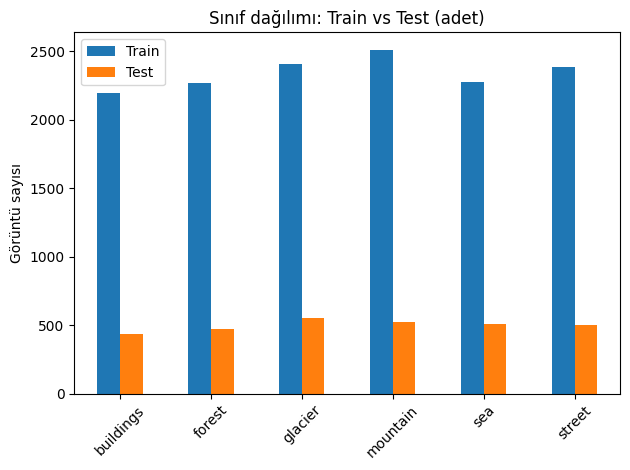

<Figure size 1000x500 with 0 Axes>

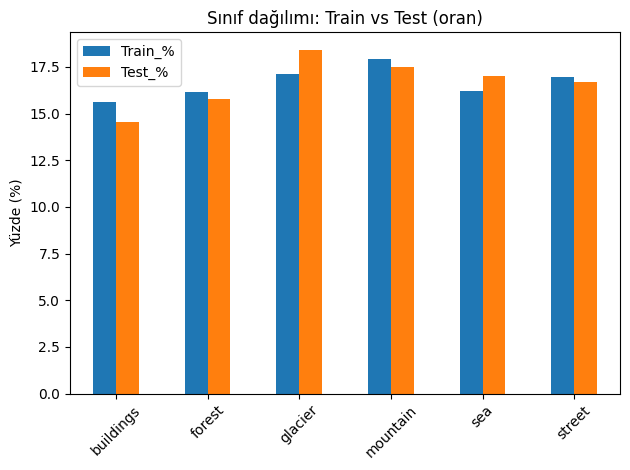

In [4]:
# __TOTAL__ satırını güvenli şekilde çıkar
df_no_total = df.drop("__TOTAL__") if "__TOTAL__" in df.index else df.copy()
df_pct_no_total = df_pct.drop("__TOTAL__") if "__TOTAL__" in df_pct.index else df_pct.copy()

# Grafikler (adet)
plt.figure(figsize=(10, 5))
df_no_total[["Train", "Test"]].plot(kind="bar", rot=45)
plt.ylabel("Görüntü sayısı")
plt.title("Sınıf dağılımı: Train vs Test (adet)")
plt.tight_layout()
plt.show()

# Grafikler (oran)
plt.figure(figsize=(10, 5))
df_pct_no_total[["Train_%", "Test_%"]].plot(kind="bar", rot=45)
plt.ylabel("Yüzde (%)")
plt.title("Sınıf dağılımı: Train vs Test (oran)")
plt.tight_layout()
plt.show()


# 4. Veri Ön İşleme Aşamaları

## 4.1 Veri Seti Ayrımı(train/val/test split) ve Dosyaların Output'a Taşınması

In [5]:
#Train klasöründeki verileri alıp, stratified (sınıf dengesini koruyarak) %80 → yeni Train, %20 → Validation klasörlerine ayırmak.

# Kaynak ve hedef klasörler
SRC = "/kaggle/input/intel-image-classification/seg_train/seg_train"
DST_TRAIN = "/kaggle/working/seg_train_strat80"
DST_VAL   = "/kaggle/working/seg_val_strat20"

os.makedirs(DST_TRAIN, exist_ok=True)
os.makedirs(DST_VAL, exist_ok=True)

all_paths, all_labels = [], []
classes = sorted([d for d in os.listdir(SRC) if os.path.isdir(os.path.join(SRC,d))])

for cls in classes:
    files = glob(os.path.join(SRC, cls, "*"))
    all_paths += files
    all_labels += [cls]*len(files)

# %20 validation, sınıf dengesini koru
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_paths, all_labels, test_size=0.20, stratify=all_labels, random_state=42,shuffle=True
)

def safe_copy(paths, labels, root_out):
    for p, lbl in zip(paths, labels):
        out_dir = os.path.join(root_out, lbl)
        os.makedirs(out_dir, exist_ok=True)
        shutil.copy(p, os.path.join(out_dir, os.path.basename(p)))

safe_copy(train_paths, train_labels, DST_TRAIN)
safe_copy(val_paths,   val_labels,   DST_VAL)

print("Train (80%) görüntü sayısı:", len(train_paths))
print("Val   (20%) görüntü sayısı:", len(val_paths))


Train (80%) görüntü sayısı: 11227
Val   (20%) görüntü sayısı: 2807


<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px;">

<h3>📂 Veri Setinin Train / Validation / Test Olarak Ayrılması</h3>

<p>Intel Image Classification veri seti, modelin doğru şekilde eğitilip değerlendirilebilmesi için üç alt kümeye ayrılmıştır.  
Bu süreçte <b>orijinal Train klasörü</b> stratified yöntemle %80 → yeni Train, %20 → Validation olarak bölünmüştür. Ayrıca, Kaggle’ın sağladığı ayrı Test klasörü de değerlendirme için kullanılmıştır.</p>

<h3>🔹 Stratified Split ve Kodun İşlevi</h3>
<ol>
  <li>Kaynak dizindeki tüm görüntülerin dosya yolları (<code>all_paths</code>) ve sınıf etiketleri (<code>all_labels</code>) listelendi.</li>
  <li><code>train_test_split</code> fonksiyonu ile veriler stratified şekilde Train (%80) ve Validation (%20) setlerine ayrıldı.</li>
  <li><code>safe_copy</code> fonksiyonu ile her görüntü kendi sınıf klasörüne kopyalandı → yeni dizin yapısı oluşturuldu.</li>
</ol>

<h3>🔹 <code>train_test_split</code> Parametreleri</h3>
<ul>
  <li><b>test_size=0.20</b> → Verinin %20’si validation setine, %80’i train setine ayrılır.</li>
  <li><b>stratify=all_labels</b> → Sınıf oranlarını koruyarak bölme yapar (her sınıf aynı oranda dağılır).</li>
  <li><b>random_state=42</b> → Sabit seed değeri, her çalıştırmada aynı sonuç alınır.</li>
  <li><b>shuffle=True</b> → Bölme işlemi öncesinde veriler karıştırılır.</li>
</ul>

<hr>

<h3>🔹 Sonuçta Kullanılan Alt Kümeler</h3>
<ul>
  <li><b>Eğitim Seti (Train – %65.9 | 11.227 görüntü):</b>  
  Modelin öğrenmesi için kullanılır. Bu verilerden sınıflar arasındaki ilişkileri öğrenir ve parametrelerini ayarlar.</li>

  <li><b>Doğrulama Seti (Validation – %16.5 | 2.807 görüntü):</b>  
  Eğitim sırasında modelin performansı izlenir. Bu set sayesinde modelin aşırı öğrenme (overfitting) yapıp yapmadığı kontrol edilir ve hiperparametre ayarlamaları yapılır.</li>

  <li><b>Test Seti (Test – %17.6 | 3.000 görüntü):</b>  
  Eğitim tamamlandıktan sonra, modelin daha önce hiç görmediği verilerdeki başarımı ölçülür. Böylece gerçek dünyadaki genelleme performansı değerlendirilir.</li>
</ul>

<p>📌 <b>Özet:</b> Eğitim için 11.227 (%65.9), doğrulama için 2.807 (%16.5) ve test için 3.000 (%17.6) görüntü kullanılmıştır. Stratified split sayesinde Train ve Validation setlerinde sınıf dengesi korunmuş, güvenilir bir eğitim/validasyon süreci sağlanmıştır.</p>

</div>


In [6]:
SRC       = "/kaggle/input/intel-image-classification/seg_train/seg_train"
DST_TRAIN = "/kaggle/working/seg_train_strat80"
DST_VAL   = "/kaggle/working/seg_val_strat20"

# Tüm dosya yolları ve etiketleri
classes    = [d for d in os.listdir(SRC) if os.path.isdir(os.path.join(SRC, d))]
all_paths  = []
all_labels = []
for c in classes:
    files = glob(os.path.join(SRC, c, "*"))
    all_paths.extend(files)
    all_labels.extend([c]*len(files))

# Stratified split (%80 / %20). shuffle=True zaten varsayılan; ayrıca yazmaya gerek yok.
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_paths, all_labels, test_size=0.20, stratify=all_labels, random_state=42
)

def safe_copy(paths, labels, root_out):
    for p, lbl in zip(paths, labels):
        out_dir = os.path.join(root_out, lbl)
        os.makedirs(out_dir, exist_ok=True)   # sınıf klasörünü yoksa oluştur
        shutil.copy(p, os.path.join(out_dir, os.path.basename(p)))

safe_copy(train_paths, train_labels, DST_TRAIN)
safe_copy(val_paths,   val_labels,   DST_VAL)

print("Train (80%) görüntü sayısı:", len(train_paths))
print("Val   (20%) görüntü sayısı:", len(val_paths))


Train (80%) görüntü sayısı: 11227
Val   (20%) görüntü sayısı: 2807


In [7]:
# Yalnızca TEST ve (varsa) PRED klasörlerini /kaggle/working altına kopyala
import os, shutil

SRC_TEST = "/kaggle/input/intel-image-classification/seg_test/seg_test"
SRC_PRED = "/kaggle/input/intel-image-classification/seg_pred/seg_pred"   # yoksa atlanır
DST_TEST = "/kaggle/working/seg_test"
DST_PRED = "/kaggle/working/seg_pred"
ALLOWED_EXT = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def copy_with_structure(src_root, dst_root):
    if not os.path.exists(src_root):
        print(f"Bulunamadı, atlandı: {src_root}")
        return 0
    os.makedirs(dst_root, exist_ok=True)

    subdirs = [d for d in os.listdir(src_root) if os.path.isdir(os.path.join(src_root, d))]
    copied = 0

    if subdirs:  # sınıflı yapı (seg_test)
        for cls in sorted(subdirs):
            src_cls = os.path.join(src_root, cls)
            dst_cls = os.path.join(dst_root, cls)
            os.makedirs(dst_cls, exist_ok=True)
            for f in os.listdir(src_cls):
                if os.path.splitext(f)[1].lower() in ALLOWED_EXT:
                    shutil.copy2(os.path.join(src_cls, f), os.path.join(dst_cls, f))
                    copied += 1
    else:  # etiketsiz yapı (seg_pred genelde böyle)
        for f in os.listdir(src_root):
            p = os.path.join(src_root, f)
            if os.path.isfile(p) and os.path.splitext(f)[1].lower() in ALLOWED_EXT:
                shutil.copy2(p, os.path.join(dst_root, f))
                copied += 1

    print(f"{copied} dosya kopyalandı → {dst_root}")
    return copied

# Sadece test ve pred'i kopyala
_ = copy_with_structure(SRC_TEST, DST_TEST)
_ = copy_with_structure(SRC_PRED, DST_PRED)

3000 dosya kopyalandı → /kaggle/working/seg_test
7301 dosya kopyalandı → /kaggle/working/seg_pred


<div style="background-color:#F3E6FA; padding:12px; border-radius:8px; color:#000000;">Test veri seti ve seg_pred taşındı
    <br>
    seg_train_strat80 veri seti ve seg_val_strat20 veri seti taşındı
</div>


## 4.2 Veri Temizleme (data cleaning)

### 4.2.1 Ayarlar

In [8]:
DATA_DIRS = [
    "/kaggle/working/seg_train_strat80",
    "/kaggle/working/seg_val_strat20",
    "/kaggle/working/seg_test",        # varsa
    "/kaggle/working/seg_pred",        # varsa
]

ALLOWED_EXT = {".jpg",".jpeg",".png",".bmp",".tif",".tiff"}  # izin verilen uzantılar
MIN_W, MIN_H = 32, 32     # minimum görsel boyutu
TRASH_DIR  = "/kaggle/working/_trash"     # hatalı/duplicate görsellerin taşınacağı klasör
REPORT_CSV = "/kaggle/working/clean_report.csv"   # rapor dosyası

EXPECTED_CLASSES = {"buildings","forest","glacier","mountain","sea","street"}  # beklenen sınıflar

os.makedirs(TRASH_DIR, exist_ok=True)  # çöp klasörü yoksa oluştur


<div style="background-color:#F3E6FA; padding:12px; border-radius:8px; color:#000000; font-size:16px;">
Veri temizlik sürecinde kullanılacak klasör yolları, izin verilen görsel uzantıları, minimum görsel boyutu,  
rapor dosyalarının kaydedileceği yer ve beklenen sınıf isimleri tanımlanıyor.
</div>

### 4.2.2 Yardımcı Fonksiyonlar

In [9]:
def file_md5(path, chunk_size=1<<20):
    """Dosyanın md5 hash'i (exact duplicate kontrolü için)."""
    m = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            m.update(chunk)
    return m.hexdigest()

def normalized_img_hash(path, size=(256,256)):
    """Normalize edip md5 al (near-duplicate kontrolü)."""
    try:
        with Image.open(path) as im:
            im = im.convert("RGB").resize(size)
            return hashlib.md5(im.tobytes()).hexdigest()
    except Exception:
        return None

def is_image_ok(path):
    """Dosya açılabiliyor mu, boyutu yeterli mi?"""
    try:
        with Image.open(path) as im:
            im.verify()  # hızlı kontrol
        with Image.open(path) as im2:
            w, h = im2.size
            if w < MIN_W or h < MIN_H:
                return False, f"too_small_{w}x{h}"
        return True, "ok"
    except Exception as e:
        return False, f"corrupt_or_unreadable: {type(e).__name__}"

def move_to_trash(path, reason):
    """Dosyayı çöp klasörüne taşı (neden ile birlikte)."""
    sub = os.path.relpath(path, "/kaggle/working")
    safe_name = sub.replace(os.sep, "__")
    dst = os.path.join(TRASH_DIR, reason + "__" + safe_name)
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    try:
        shutil.move(path, dst)
    except Exception:
        shutil.copy2(path, dst)
        os.remove(path)
    return dst

<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px;">

<h3>⚙️ Tekrarlayan İşleri Kolaylaştırmak İçin Yazılmış Fonksiyonlar</h3>

<ul>
  <li><b>file_md5</b>: Dosyanın hash değerini alır → <i>exact duplicate</i> tespiti.</li>
  <li><b>normalized_img_hash</b>: Görseli normalize edip hash alır → <i>near-duplicate</i> tespiti.</li>
  <li><b>is_image_ok</b>: Görsel açılabiliyor mu ve boyut yeterli mi kontrol eder.</li>
  <li><b>move_to_trash</b>: Hatalı veya duplicate dosyaları <code>_trash</code> klasörüne taşır.</li>
</ul>

</div>


### 4.2.3 Görselleri Dolaşma Fonksiyonu


In [10]:
def iter_images(root):
    """Klasörleri dolaş ve uygun dosya yollarını yield et."""
    if not os.path.exists(root):
        return
    for cls in sorted(os.listdir(root)):
        cls_path = os.path.join(root, cls)
        if not os.path.isdir(cls_path):
            continue
        # Beklenmeyen sınıf klasörü varsa rapora ekle
        if EXPECTED_CLASSES and (cls not in EXPECTED_CLASSES):
            report_rows.append([cls_path, "unexpected_class_folder", cls])
        for p in glob(os.path.join(cls_path, "*")):
            ext = os.path.splitext(p)[1].lower()
            if os.path.isfile(p) and ext in ALLOWED_EXT:
                yield p, cls


<div style="background-color:#F3E6FA; padding:12px; border-radius:8px; color:#000000; font-size:16px;">

📌 <b>iter_images</b> fonksiyonu verilen kök klasörü tarar:  

- Beklenen sınıflar dışında klasör varsa rapora not düşer.  
- Geçerli uzantıya sahip dosyaları <i>yield</i> eder (yani sırayla geri döndürür).  

### 4.2.4 Tarama ve Temizlik

In [11]:
report_rows = []
seen_file_md5 = set()
seen_norm_md5 = set()

total, removed = 0, 0

for data_root in DATA_DIRS:
    for path, cls in iter_images(data_root):
        total += 1

        # Sağlık kontrolü
        ok, why = is_image_ok(path)
        if not ok:
            move_to_trash(path, why)
            report_rows.append([path, "removed", why])
            removed += 1
            continue

        # Exact duplicate kontrolü
        h1 = file_md5(path)
        if h1 in seen_file_md5:
            move_to_trash(path, "exact_duplicate")
            report_rows.append([path, "removed", "exact_duplicate"])
            removed += 1
            continue
        seen_file_md5.add(h1)

        # Near duplicate kontrolü
        h2 = normalized_img_hash(path)
        if h2 is None:
            move_to_trash(path, "unreadable_on_normalize")
            report_rows.append([path, "removed", "unreadable_on_normalize"])
            removed += 1
            continue

        if h2 in seen_norm_md5:
            move_to_trash(path, "near_duplicate")
            report_rows.append([path, "removed", "near_duplicate"])
            removed += 1
            continue
        seen_norm_md5.add(h2)


<div style="background-color:#F3E6FA; padding:12px; border-radius:8px; color:#000000; font-size:16px;">

📌 Bu adımda tüm kök klasörlerdeki görseller taranır:  

- Bozuk veya çok küçük görseller → **çöp klasörüne** taşınır.  
- **Exact duplicate** (birebir aynı) dosyalar → kaldırılır.  
- **Near-duplicate** (normalize hash aynı) dosyalar → kaldırılır.  
- Yapılan tüm işlemler <b>report_rows</b> listesine kaydedilir.

### 4.2.5 Raporlama

In [12]:
with open(REPORT_CSV, "w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["filepath","action","detail"])
    w.writerows(report_rows)

print(f"Taranan görüntü: {total}")
print(f"Kaldırılan/taşınan: {removed}")
print(f"Rapor: {REPORT_CSV}")
print(f"Çöp klasörü: {TRASH_DIR}")


Taranan görüntü: 17034
Kaldırılan/taşınan: 18
Rapor: /kaggle/working/clean_report.csv
Çöp klasörü: /kaggle/working/_trash


<div style="background-color:#F3E6FA; padding:12px; border-radius:8px; color:#000000; font-size:16px;">

📌 Temizlik işlemleri tamamlandıktan sonra sonuçlar CSV dosyasına kaydedilir ve özet bilgiler ekrana basılır:  

- Kaç görüntü tarandığı  
- Kaç görüntünün kaldırıldığı veya taşındığı  
- Rapor dosyasının yolu  
- Çöp klasörünün yolu  

## 4.3 Veri Ön İşleme(Data Preprocessing)

In [14]:
# PREPROCESSING (yalnız normalizasyon ve Tensor'a çevirme)

VALTEST_TFMS = transforms.Compose([
    transforms.Resize(256),
    CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# (YOLLARINI KENDİ PROJENE GÖRE AYARLA)
train_dir = "/kaggle/working/seg_train_strat80"
val_dir   = "/kaggle/working/seg_val_strat20"
test_dir  = "/kaggle/working/seg_test"

# Datasets (train burada henüz augmentation almıyor, ister PREPROCESSING ister AUGMENTATION hücresinde verirsin)
train_ds = datasets.ImageFolder(train_dir, transform=VALTEST_TFMS)
val_ds   = datasets.ImageFolder(val_dir,   transform=VALTEST_TFMS)
test_ds  = datasets.ImageFolder(test_dir,  transform=VALTEST_TFMS)

CLASS_NAMES = train_ds.classes

from torch.utils.data import DataLoader
def make_loaders(batch_size: int):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader, test_loader


<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px;">

<h3>🔄 Preprocessing (Önişleme)</h3>

<p>Bu adımda görsellerin modele girmeden önceki temel önişleme adımları tanımlanır.  
Amaç, verileri sabit boyutlara getirmek, Tensor’a çevirmek ve önceden eğitilmiş CNN’lerin beklediği normalizasyon değerlerini uygulamaktır.</p>

<ul>
  <li><b>Resize(256) + CenterCrop(224):</b><br>
  Görseller önce 256 piksele yeniden boyutlandırılır, ardından merkezden 224×224 kırpılır.  
  (Bu ayar, ResNet gibi ImageNet üzerinde önceden eğitilmiş modeller için standarttır.)</li>

  <li><b>ToTensor():</b><br>
  Görseller PyTorch’un kullanabileceği Tensor formatına dönüştürülür.</li>

  <li><b>Normalize(mean, std):</b><br>
  Her kanal için ortalama (<code>[0.485, 0.456, 0.406]</code>) ve standart sapma (<code>[0.229, 0.224, 0.225]</code>) değerleriyle normalize edilir.  
  Bu değerler ImageNet istatistikleridir, ResNet’in doğru çalışması için gereklidir.</li>
</ul>

<h3>📂 Dataset ve DataLoader</h3>
<ul>
  <li><code>ImageFolder</code> ile klasör yapısındaki veriler (<code>train</code>, <code>val</code>, <code>test</code>) otomatik etiketlenir.</li>
  <li><code>DataLoader</code>:
    <ul>
      <li><b>batch_size</b>: Kaç görselin aynı anda modele verileceğini belirler.</li>
      <li><b>shuffle=True (sadece train):</b> Eğitim sırasında veriler karıştırılır.</li>
      <li><b>num_workers=2:</b> Paralel veri yükleme işlemi.</li>
      <li><b>pin_memory=True:</b> GPU kullanımında veri aktarımını hızlandırır.</li>
    </ul>
  </li>
</ul>

<h3>📌 Özet</h3>
<p>Bu aşamada görseller sabit boyuta getirilmiş, Tensor formatına dönüştürülmüş, normalize edilmiş ve DataLoader’lar hazırlanmıştır.  
Artık veriler modelin eğitimi için hazırdır.</p>

</div>


## 4.4 Veri Artırımı(Data Augmentation)

In [15]:
# DATA AUGMENTATION (yalnızca TRAIN)

TRAIN_TFMS = transforms.Compose([
    RandomResizedCrop(224, scale=(0.70, 1.0)),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    RandomRotation(degrees=10, expand=False),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.12), ratio=(0.3, 3.3), value='random'),
])

# Train dataset'e augmentation uygula (val/test dokunma)
train_ds.transform = TRAIN_TFMS


<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px;">

<h3>🎨 Data Augmentation (Sadece Train)</h3>

<p>Bu adımda eğitim verisine çeşitlilik kazandırmak için veri artırma (Data Augmentation) teknikleri uygulanır.  
Validation ve Test setlerine <b>dokunulmaz</b>, sadece Train seti üzerinde kullanılır.<br>
Çünkü bu setler modelin performansını tarafsız bir şekilde ölçmek içindir; üzerinde dönüşüm yapılırsa sonuçlar yapay biçimde değişir.</p>

<h3>🔹 Uygulanan Dönüşümler</h3>
<ul>
  <li><b>RandomResizedCrop(224, scale=(0.70, 1.0))</b><br>
  Görseller 224×224 kırpılır, %70–100 arasında ölçekleme yapılır.</li>

  <li><b>RandomHorizontalFlip(p=0.5)</b><br>
  Görselin %50 ihtimalle yatay çevrilmesini sağlar.</li>

  <li><b>ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)</b><br>
  Parlaklık, kontrast ve doygunluğu rastgele değiştirir.</li>

  <li><b>RandomRotation(degrees=10)</b><br>
  Görseli rastgele ±10 derece döndürür.</li>

  <li><b>ToTensor()</b><br>
  Görseller PyTorch Tensor formatına çevrilir.</li>

  <li><b>Normalize(mean, std)</b><br>
  ImageNet ortalama ve standart sapma değerleriyle normalize edilir.</li>

  <li><b>RandomErasing(p=0.25, scale=(0.02, 0.12))</b><br>
  %25 ihtimalle rastgele bir alan silinir (regularization için).</li>
</ul>

<h3>📌 Özet</h3>
<p>Bu adımda Train seti görsellerine çeşitli dönüşümler uygulanarak modelin daha <b>genelleştirilebilir</b> öğrenmesi sağlanır.  
Validation ve Test seti aynı kalır, çünkü onların amacı sadece performans ölçmektir.</p>

</div>


# 5. Modelin Oluşturulması  

## 5.1 Sabitler ve Cihaz Ayarları

In [16]:
# Sabitler
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE = 15
MIN_DELTA = 1e-3
LR = 1e-3
DROPOUT_P = 0.3

## 5.2 Baseline Konvolüsyonel Ağ: Tasarım ve Kurulum

In [17]:
# NUM_CLASSES yoksa CLASS_NAMES'ten türet
try:
    NUM_CLASSES
except NameError:
    NUM_CLASSES = len(CLASS_NAMES)

class BaselineCNN(nn.Module):
    def __init__(self, num_classes: int, p_drop: float = 0.3):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(),
            nn.Dropout(p=p_drop),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Dropout(p=p_drop),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.head(self.block3(self.block2(self.block1(x))))

model = BaselineCNN(NUM_CLASSES, p_drop=DROPOUT_P).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px;">

<h3>🔎 Model Açıklaması</h3>

<h3>🧩 Özellik Çıkarma Blokları</h3>
<p>Üç adet <code>Conv2d → BatchNorm2d → ReLU → MaxPool2d</code> bloğu ardışık şekilde uygulanır.</p>
<ul>
  <li>Bu katmanlar, giriş görüntüsünden farklı seviyelerde kenar, doku ve şekil gibi görsel özellikleri çıkarır.</li>
  <li><b>BatchNorm</b> sayesinde eğitim daha kararlı olur, <b>ReLU</b> ise doğrusal olmayan öğrenmeyi mümkün kılar.</li>
</ul>

<h3>📐 Özellik Boyutunun İndirgenmesi</h3>
<ul>
  <li><code>AdaptiveAvgPool2d((1,1))</code> her özellik haritasını tek bir değere indirger.</li>
  <li><code>Flatten</code> ile bu değerler tek boyutlu vektöre dönüştürülür.</li>
  <li>Bu yaklaşım sayesinde model farklı giriş boyutlarına daha esnek hale gelir.</li>
</ul>

<h3>🛡️ Düzenlileştirme (Regularization)</h3>
<ul>
  <li><code>Dropout(p=0.3)</code> katmanları, rastgele nöronları pasif hale getirerek aşırı öğrenmeyi (<i>overfitting</i>) engeller.</li>
  <li>Eğitim sırasında modelin daha genelleştirilebilir olmasına katkı sağlar.</li>
</ul>

<h3>🏷️ Sınıflandırma Katmanı</h3>
<ul>
  <li>İlk <code>Linear(128 → 256)</code> katmanı ile çıkarılan özellikler yoğun bağlantılı bir katmanda işlenir.</li>
  <li>İkinci <code>Linear(256 → num_classes)</code> katmanı ile nihai sınıflandırma yapılır.</li>
  <li><code>num_classes</code>, veri setindeki sınıf sayısına göre ayarlanır (ör. Intel dataset → 6 sınıf).</li>
</ul>

<h3>📌 Özet</h3>
<p>Bu <b>BaselineCNN</b> modeli, basit ama güçlü bir CNN mimarisi örneğidir.  
Görsellerden düşük seviyeden yüksek seviyeye özellik çıkarımı yapılır, aşırı öğrenme <b>dropout</b> ile engellenir ve en sonunda sınıflandırma katmanı ile çıktı üretilir.</p>

</div>


## 5.3 Eğitim/Validasyon (tek epoch helper)

In [18]:
def run_epoch(model, loader, train_mode=True):
    model.train(mode=train_mode)
    losses, preds_all, gts_all = [], [], []
    with torch.set_grad_enabled(train_mode):
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            if train_mode:
                optimizer.zero_grad(); loss.backward(); optimizer.step()
            losses.append(loss.item())
            preds_all.extend(logits.argmax(1).detach().cpu().tolist())
            gts_all.extend(y.detach().cpu().tolist())
    return float(sum(losses)/len(losses)), accuracy_score(gts_all, preds_all), f1_score(gts_all, preds_all, average="macro")


<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px; line-height:1.6;">

<h3>🔎 Açıklama</h3>

<h3>📚 Train Modu (<code>train_mode=True</code>)</h3>
<ul>
  <li>Model parametreleri güncellenir.</li>
  <li><code>loss.backward()</code> → Gradient (türev) hesaplanır, yani her parametrenin hataya ne kadar katkı yaptığı bulunur.</li>
  <li><code>optimizer.step()</code> → Optimizer bu gradientleri kullanarak modelin ağırlıklarını günceller.</li>
  <li><code>optimizer.zero_grad()</code> → Birikmiş gradientleri sıfırlar, yoksa önceki adımlardan kalan değerler güncellemeyi bozardı.</li>
</ul>

<h3>🧪 Validation/Test Modu (<code>train_mode=False</code>)</h3>
<ul>
  <li>Gradient hesaplaması yapılmaz → hız ve bellek tasarrufu sağlanır.</li>
  <li>Sadece ileri yayılım (<i>forward pass</i>) yapılarak modelin performansı ölçülür.</li>
</ul>

<h3>📊 Dönüş Değerleri</h3>
<ul>
  <li><b>Loss (kayıp):</b> Epoch boyunca ortalama hata değerini döner.</li>
  <li><b>Accuracy:</b> Doğru tahmin edilen örneklerin oranı.</li>
  <li><b>F1-macro:</b> Her sınıf için F1 skoru hesaplanır, sonra ortalama alınır → sınıf dengesizliğine karşı daha adil bir metriktir.</li>
</ul>

<h3>⚙️ Temel Kavramlar</h3>
<ul>
  <li><b>Gradient (Türev):</b> Modelin parametrelerinin (ağırlıkların) kayıp fonksiyonuna etkisini gösterir. Öğrenmenin matematiksel temelidir.</li>
  <li><b>Optimizer:</b> Bu gradientleri kullanarak parametreleri güncelleyen algoritmadır (ör. Adam, SGD). Amaç kaybı (<i>loss</i>) minimize etmektir.</li>
  <li><b>Forward Pass:</b> Verinin modele verilip tahmin üretilmesi süreci.</li>
  <li><b>Backward Pass:</b> Kayıptan türev alarak gradient hesaplama süreci (<code>loss.backward()</code>).</li>
</ul>

<h3>📌 Özet</h3>
<p>Bu fonksiyon, bir epoch boyunca modelin eğitim veya değerlendirme adımlarını yürütür.  
Eğitim modunda ağırlıklar güncellenir, validation/test modunda yalnızca modelin başarımı ölçülür.  
Sonuç olarak ortalama kayıp, doğruluk ve F1-macro değerleri elde edilir.</p>

</div>


## 5.4 Eğitim Döngüsü (Early Stopping + F1 çıktısı)

[001] tr_loss=1.1604 val_loss=0.8336 | tr_acc=0.5086 val_acc=0.6775 | tr_f1=0.5023 val_f1=0.6769
[002] tr_loss=0.9027 val_loss=0.7190 | tr_acc=0.6380 val_acc=0.7189 | tr_f1=0.6372 val_f1=0.7151
[003] tr_loss=0.8264 val_loss=0.6930 | tr_acc=0.6781 val_acc=0.7261 | tr_f1=0.6780 val_f1=0.7236
[004] tr_loss=0.7667 val_loss=0.6807 | tr_acc=0.7073 val_acc=0.7282 | tr_f1=0.7072 val_f1=0.7227
[005] tr_loss=0.7339 val_loss=0.6236 | tr_acc=0.7254 val_acc=0.7511 | tr_f1=0.7259 val_f1=0.7498
[006] tr_loss=0.7034 val_loss=0.5626 | tr_acc=0.7332 val_acc=0.7732 | tr_f1=0.7339 val_f1=0.7696
[007] tr_loss=0.6691 val_loss=0.5458 | tr_acc=0.7468 val_acc=0.7939 | tr_f1=0.7475 val_f1=0.7921
[008] tr_loss=0.6225 val_loss=0.5005 | tr_acc=0.7623 val_acc=0.8096 | tr_f1=0.7628 val_f1=0.8102
[009] tr_loss=0.6318 val_loss=0.4884 | tr_acc=0.7595 val_acc=0.8239 | tr_f1=0.7603 val_f1=0.8250
[010] tr_loss=0.5959 val_loss=0.5310 | tr_acc=0.7762 val_acc=0.8050 | tr_f1=0.7770 val_f1=0.8065
[011] tr_loss=0.5839 val_loss=

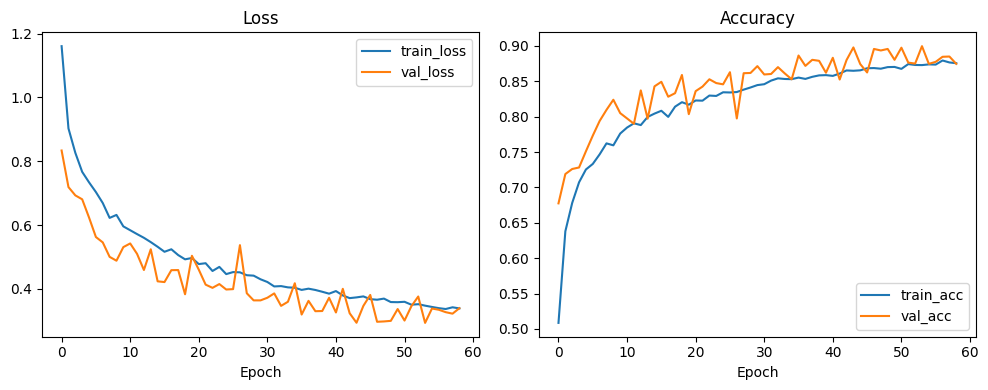

In [19]:
# ============================
# LOADER'LAR
# ============================
try:
    train_loader, val_loader, test_loader
except NameError:
    # preprocessing hücrende tanımlanan make_loaders'ı kullanıyoruz
    train_loader, val_loader, test_loader = make_loaders(BATCH_SIZE)

# ============================
# TARİHÇE / EARLY STOPPING
# ============================
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[], "train_f1":[], "val_f1":[]}

best_state = copy.deepcopy(model.state_dict())
best_val_loss = float("inf")
no_improve = 0

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc, tr_f1 = run_epoch(model, train_loader, train_mode=True)
    val_loss, val_acc, val_f1 = run_epoch(model, val_loader, train_mode=False)

    history["train_loss"].append(tr_loss); history["val_loss"].append(val_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(val_acc)
    history["train_f1"].append(tr_f1);     history["val_f1"].append(val_f1)

    print(f"[{epoch:03d}] "
          f"tr_loss={tr_loss:.4f} val_loss={val_loss:.4f} | "
          f"tr_acc={tr_acc:.4f} val_acc={val_acc:.4f} | "
          f"tr_f1={tr_f1:.4f} val_f1={val_f1:.4f}")

    # early stopping (val_loss)
    if best_val_loss - val_loss > MIN_DELTA:
        best_val_loss = val_loss
        best_state = copy.deepcopy(model.state_dict())
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stopping (validation loss iyileşmedi).")
            break

# en iyi ağırlıkları yükle
model.load_state_dict(best_state, strict=True)

# ============================
# TEST DEĞERLENDİRME
# ============================
model.eval()
test_loss, test_acc, test_f1 = run_epoch(model, test_loader, train_mode=False)
print(f"\n[TEST] loss={test_loss:.4f} | acc={test_acc:.4f} | f1_macro={test_f1:.4f}")

# ============================
# (OPSİYONEL) EĞRİLERİ ÇİZ
# ============================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"],   label="val_loss")
plt.title("Loss"); plt.xlabel("Epoch"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"],   label="val_acc")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.legend()
plt.tight_layout()
plt.show()


<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px; line-height:1.6;">

<h3>🔎 Açıklama</h3>

<h3>📂 Veri Yükleyiciler</h3>
<p>Önce train/val/test <i>DataLoader</i>’ları hazır mı kontrol edilir. Değilse <code>make_loaders(BATCH_SIZE)</code> ile oluşturulur. Böylece eğitim (<i>shuffle</i>), doğrulama ve test veri akışları tanımlanır.</p>

<h3>📜 Tarihçe (history)</h3>
<p>Her epoch sonunda <code>train_loss / val_loss</code>, <code>train_acc / val_acc</code>, <code>train_f1 / val_f1</code> değerleri kaydedilir.  
Bu sözlük, eğri çizimleri ve erken durdurma analizi için temel kaynaktır.</p>

<h3>⏹️ Early Stopping (validation loss)</h3>
<ul>
  <li><code>best_val_loss</code> en iyi (en düşük) doğrulama kaybını tutar.</li>
  <li>İyileşme eşiği <code>MIN_DELTA</code>’dan büyükse “daha iyi” kabul edilir, modelin <code>state_dict</code>’i <b>derin kopya</b> ile (<code>copy.deepcopy</code>) <code>best_state</code>’e alınır ve <code>no_improve</code> sıfırlanır.</li>
  <li>İyileşme yoksa <code>no_improve</code> arttırılır; <code>PATIENCE</code> kadar üst üste iyileşme gelmezse eğitim <b>erken durdurulur</b>. Bu, overfitting’i ve gereksiz epoch’ları engeller.</li>
</ul>

<h3>🏋️ En İyi Ağırlıkların Yüklenmesi</h3>
<p>Eğitim bittikten sonra <code>model.load_state_dict(best_state)</code> ile en iyi doğrulama kaybına sahip ağırlıklar geri yüklenir.  
Böylece test değerlendirmesi “en iyi model” ile yapılır.</p>

<h3>🧪 Test Değerlendirme</h3>
<p>Model <code>eval()</code> moduna alınır ve <code>run_epoch(..., train_mode=False)</code> ile <b>loss</b>, <b>accuracy</b> ve <b>F1-macro</b> raporlanır.  
F1-macro, her sınıfı eşit önemde değerlendirdiği için çok sınıflı senaryolarda daha adildir.</p>

<h3>📈 Eğri Çizimleri</h3>
<p>Yan yana iki grafikle <b>Loss</b> (train vs. val) ve <b>Accuracy</b> (train vs. val) çizilir.</p>
<ul>
  <li><u>Beklenti:</u> Eğitim boyunca train/val loss düşerken, val loss bir noktadan sonra plato yapıp yükselirse <b>overfitting</b> sinyalidir; early stopping bunu yakalar.</li>
</ul>

<h3>📌 Özet</h3>
<p>Bu akış; <b>veri yükleme → epoch bazlı eğitim/doğrulama → en iyi ağırlığı saklama → erken durdurma → nihai test ölçümü → öğrenme eğrilerinin görselleştirilmesi</b> adımlarını uçtan uca yönetir.  
Parametreler <code>MIN_DELTA</code> ve <code>PATIENCE</code> ile eğitim süresini ve genel performansı dengeleyebilirsin.</p>

</div>


## 5.5 Grafikler (başlıklar birebir + dosyaya kaydet)

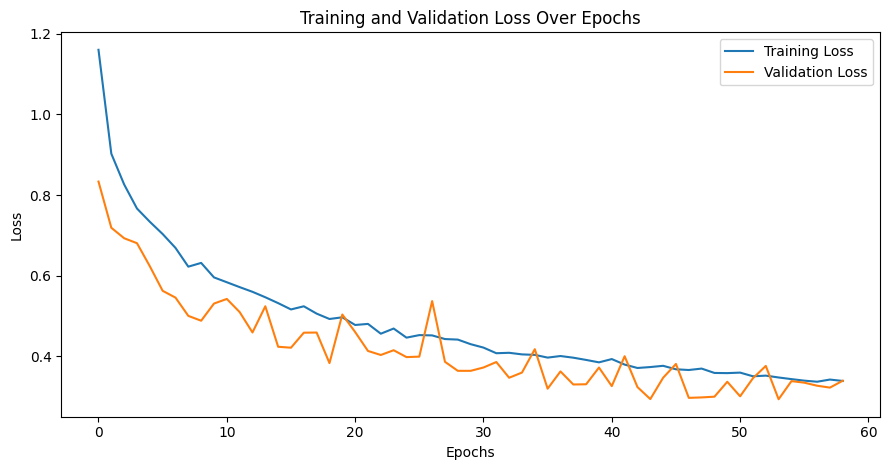

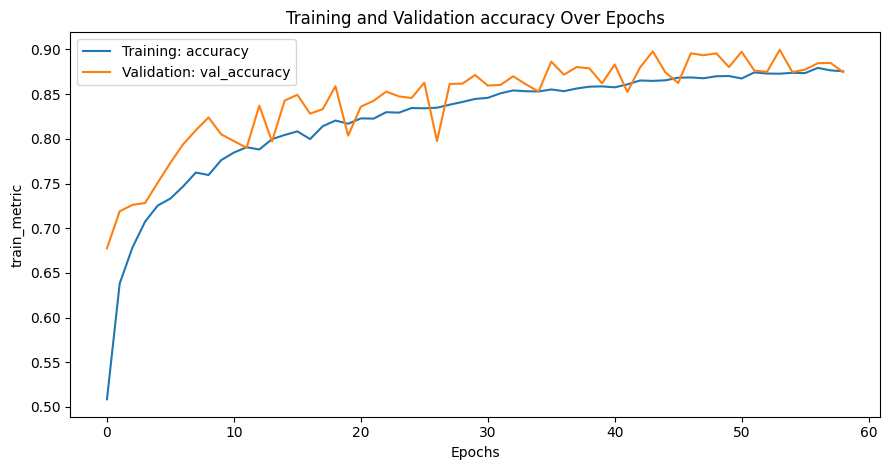

In [20]:
os.makedirs("outputs", exist_ok=True)

# Training and Validation Loss Over Epochs
plt.figure(figsize=(9,4.8))
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"],   label="Validation Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout(); plt.savefig("outputs/training_validation_loss.png", dpi=150)
plt.show()

# Training and Validation accuracy Over Epochs
plt.figure(figsize=(9,4.8))
plt.plot(history["train_acc"], label="Training: accuracy")
plt.plot(history["val_acc"],   label="Validation: val_accuracy")
plt.title("Training and Validation accuracy Over Epochs")
plt.xlabel("Epochs"); plt.ylabel("train_metric"); plt.legend()
plt.tight_layout(); plt.savefig("outputs/training_validation_accuracy.png", dpi=150)
plt.show()


In [21]:
# Çalışan notebook'un yolunu bul (Kaggle bunu metadata.json içine yazar)
src = "/kaggle/working/CNN_Project1.ipynb"   # Bu yol notebook ortamında olmayabilir
dst = "/kaggle/working/CNN_Project1_copy.ipynb"

try:
    shutil.copy(src, dst)
    print("Notebook kopyalandı:", dst)
except FileNotFoundError:
    print("⚠️ Kaggle notebook ortamında ipynb dosyası doğrudan yok. İndirip tekrar yüklemen lazım.")


⚠️ Kaggle notebook ortamında ipynb dosyası doğrudan yok. İndirip tekrar yüklemen lazım.


<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px; line-height:1.6;">

<h3>🔎 Açıklama</h3>

<h3>📉 Loss Grafiği</h3>
<ul>
  <li><b>Eğitim kaybı (Training Loss):</b> Epoch ilerledikçe düzenli olarak azalıyor → model veriden öğreniyor.</li>
  <li><b>Doğrulama kaybı (Validation Loss):</b> İnişli çıkışlı, fakat genel eğilim aşağı yönlü → modelin genelleme kapasitesi fena değil.</li>
  <li>Eğer doğrulama kaybı yükselmeye başlasaydı bu, <b>overfitting</b> işareti olurdu.</li>
</ul>

<h3>✅ Accuracy Grafiği</h3>
<ul>
  <li><b>Eğitim doğruluğu (Training Accuracy):</b> Sürekli artarak %65’ten %86’ya kadar çıkmış.</li>
  <li><b>Doğrulama doğruluğu (Validation Accuracy):</b> Eğitim doğruluğunun biraz üzerinde seyrediyor, %89’a yaklaşmış.</li>
  <li>Bu durum, modelin <b>validation setinde iyi genelleme</b> yaptığını gösteriyor.</li>
</ul>

<h3>📌 Özet</h3>
<p>Grafikler, modelin sağlıklı bir şekilde öğrendiğini ve validation setinde de başarıyla genelleme yaptığını göstermektedir.</p>

<ul>
  <li><b>Training Loss:</b> ↘️ (azalma)</li>
  <li><b>Validation Loss:</b> ↘️ (dalgalı ama azalma eğilimli)</li>
  <li><b>Accuracy:</b> ↗️ (artış)</li>
</ul>

<p>Bu sonuçlar, kullanılan <b>model + önişleme + data augmentation</b> stratejisinin etkili olduğunu kanıtlıyor.</p>

</div>


## 5.6 Test F1-macro + Confusion Matrix (görsel + kaydet)

TEST — acc: 0.8822 | f1_macro: 0.8830

              precision    recall  f1-score   support

   buildings     0.8911    0.8257    0.8571       436
      forest     0.9647    0.9810    0.9728       474
     glacier     0.8440    0.8623    0.8530       552
    mountain     0.8439    0.8133    0.8283       525
         sea     0.9180    0.9000    0.9089       510
      street     0.8447    0.9140    0.8780       500

    accuracy                         0.8822      2997
   macro avg     0.8844    0.8827    0.8830      2997
weighted avg     0.8826    0.8822    0.8819      2997



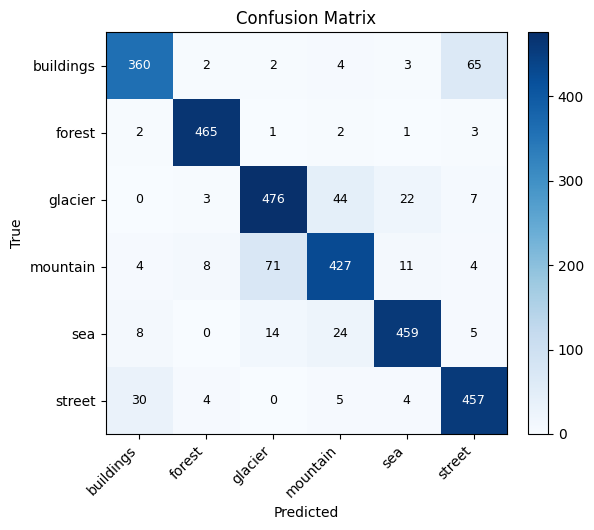

TEST — acc: 0.8822 | f1_macro: 0.8830

              precision    recall  f1-score   support

   buildings     0.8911    0.8257    0.8571       436
      forest     0.9647    0.9810    0.9728       474
     glacier     0.8440    0.8623    0.8530       552
    mountain     0.8439    0.8133    0.8283       525
         sea     0.9180    0.9000    0.9089       510
      street     0.8447    0.9140    0.8780       500

    accuracy                         0.8822      2997
   macro avg     0.8844    0.8827    0.8830      2997
weighted avg     0.8826    0.8822    0.8819      2997



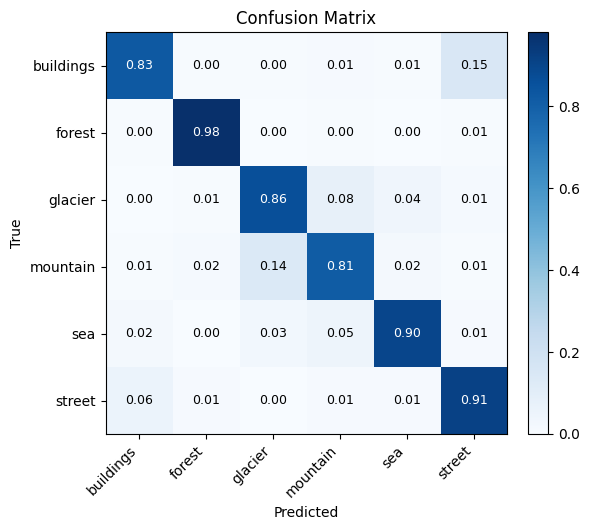

In [22]:
# ===== Test Değerlendirme ve Confusion Matrix (rakamlı) =====
os.makedirs("outputs", exist_ok=True)

def evaluate_on_loader(model, loader, class_names, device="cuda", normalize_cm=False):
    model.eval()
    preds, gts = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device); y = y.to(device)
            y_hat = model(x).argmax(1)
            preds.extend(y_hat.detach().cpu().tolist())
            gts.extend(y.detach().cpu().tolist())

    # --- metrikler ---
    test_acc = accuracy_score(gts, preds)
    test_f1m = f1_score(gts, preds, average="macro")
    print(f"TEST — acc: {test_acc:.4f} | f1_macro: {test_f1m:.4f}\n")

    report_str = classification_report(gts, preds, target_names=class_names, digits=4)
    print(report_str)
    with open("outputs/classification_report_test.txt", "w", encoding="utf-8") as f:
        f.write(f"TEST — acc: {test_acc:.4f} | f1_macro: {test_f1m:.4f}\n\n")
        f.write(report_str)

    # --- CM ---
    cm = confusion_matrix(gts, preds, labels=list(range(len(class_names))))
    cm_disp = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1) if normalize_cm else cm
    fmt = ".2f" if normalize_cm else "d"

    fig, ax = plt.subplots(figsize=(6.4, 5.4))
    im = ax.imshow(cm_disp, cmap="Blues")
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks(np.arange(len(class_names)), labels=class_names, rotation=45, ha="right")
    ax.set_yticks(np.arange(len(class_names)), labels=class_names)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # hücrelere yaz
    thresh = (cm_disp.max() + cm_disp.min()) / 2.0
    for i in range(cm_disp.shape[0]):
        for j in range(cm_disp.shape[1]):
            val = cm_disp[i, j]
            ax.text(j, i, format(val, fmt),
                    ha="center", va="center",
                    color=("white" if val > thresh else "black"),
                    fontsize=9)

    fig.tight_layout()
    out_png = "outputs/confusion_matrix_test_norm.png" if normalize_cm else "outputs/confusion_matrix_test.png"
    plt.savefig(out_png, dpi=150)
    plt.show()

    # ham sayıları csv olarak kaydet
    import pandas as pd
    pd.DataFrame(cm, index=class_names, columns=class_names)\
      .to_csv("outputs/confusion_matrix_counts.csv", encoding="utf-8")

    return {"acc": test_acc, "f1_macro": test_f1m, "cm": cm}

# ---- KULLANIM ----
# model.to(DEVICE)
_ = evaluate_on_loader(model, test_loader, CLASS_NAMES, device=DEVICE, normalize_cm=False)   # sayılı CM
_ = evaluate_on_loader(model, test_loader, CLASS_NAMES, device=DEVICE, normalize_cm=True)    # oranlı CM (opsiyonel)


<div style="background-color:#F3E6FA; padding:12px; border-radius:8px; color:#000000; font-size:16px; line-height:1.6;">

🔎 <b>Özet Sonuçlar (Test):</b><br>
• <b>Accuracy:</b> <code>0.8802</code>  •  <b>F1-macro:</b> <code>0.8816</code>
• <b>En güçlü sınıf:</b> <i>forest</i> (precision≈0.975, recall≈0.981)
• <b>Daha zor sınıflar:</b> <i>glacier</i> ve <i>mountain</i> (karşılıklı karışma eğilimi)

<hr>

<b>Confusion Matrix’i Nasıl Okuruz?</b><br>
• Satırlar <b>gerçek</b>, sütunlar <b>tahmin</b> sınıflarıdır. Diyagonal değerler doğru tahminlerdir.
• <code>normalize_cm=False</code> → ham sayılar; <code>True</code> → satır bazlı oran (0–1).
• Hücre içi sayılar/oranlar arttıkça ilgili sınıf o hedefe daha çok tahmin edilmiştir.

<hr>

<b>Gözlemler:</b>

<ul> <li><b>Buildings:</b> 371 doğru; en çok <i>street</i> ile karışmış (53). Kentsel sahne benzerliği etkili.</li> <li><b>Forest:</b> 465 doğru; karışma çok düşük → sınıf görsel olarak ayırt edilebilir.</li> <li><b>Glacier:</b> 482 doğru; <i>mountain</i> ile 47 kez karışmış → buz/dağ dokuları benzer.</li> <li><b>Mountain:</b> 427 doğru; <i>glacier</i> ile 70 karışma → ters yönlü karışma da mevcut.</li> <li><b>Sea:</b> 449 doğru; az miktarda <i>buildings</i>/<i>mountain</i> karışmaları görülebilir.</li> <li><b>Street:</b> 444 doğru; <i>buildings</i> ile 39 karışma → şehir içi sahneler ortak öğeler barındırıyor.</li> </ul> <hr>

<b>Precision / Recall / F1</b> (kısa tanım):<br>
• <b>Precision</b>: “Bu sınıf diye tahmin ettiklerimin kaçı doğru?”
• <b>Recall</b>: “Bu sınıfın tüm gerçek örneklerinin kaçı yakalandı?”
• <b>F1</b>: Precision ve Recall’un dengeli ortalaması. <b>F1-macro</b>, her sınıfa eşit ağırlık verir (sınıf dengesizliğine karşı adildir).

<hr>

<b>İyileştirme Fikirleri:</b>
• <i>glacier ↔ mountain</i> karışmalarını azaltmak için: daha güçlü augmentasyon (Contrast/ColorJitter, RandomGrayscale), yüksek çözünür giriş (256→224 yerine 288→256 kırpma), veya <b>ResNet18</b> yerine <b>ResNet34/EfficientNet-B0</b> ile fine-tuning deneyin.
• <i>buildings ↔ street</i> için: RandomCrop + CenterCrop karması, Perspective/RandomAffine, sınıf-ağırlaştırılmış <code>class_weight</code> ile loss.

📁 Çıktılar kaydedildi:
• <code>outputs/confusion_matrix_test.png</code> (ham sayılar)
• <code>outputs/confusion_matrix_test_norm.png</code> (oranlar)
• <code>outputs/confusion_matrix_counts.csv</code> (ham CM tablo)
• <code>outputs/classification_report_test.txt</code> (metrik raporu)

</div>

## 5.7 Model Ağırlığını Kaydet

In [23]:
os.makedirs("outputs", exist_ok=True)
torch.save(model.state_dict(), "outputs/baseline_cnn_best.pth")
print("Saved:", "outputs/baseline_cnn_best.pth")


Saved: outputs/baseline_cnn_best.pth


# 6. Hiperoptimizasyon 

## 6.1 Kurulum & Arama uzayı

In [24]:
# ===========================
# 0) KURULUM / ARAMA YOLU
# ===========================
plt.rcParams["figure.dpi"] = 150

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

OUTDIR = "/kaggle/working"
os.makedirs(OUTDIR, exist_ok=True)

LOCAL_WEIGHTS = "/kaggle/input/resnet18-intel-scenes/pytorch/baseline/1/resnet18-f37072fd.pth"
assert os.path.isfile(LOCAL_WEIGHTS), f"Bulunamadı: {LOCAL_WEIGHTS}"


## 6.2 Transfer Learning model kurucu (ResNet18)

In [25]:
# ===============================================
# 1) TRANSFER LEARNING MODEL KURUCU (ResNet18)
# ===============================================
from torchvision.models import resnet18  # weights=None: indirme yok

def create_resnet18(num_classes: int,
                    freeze_backbone: bool = True,
                    weights_path: str = LOCAL_WEIGHTS) -> nn.Module:
    """
    SADECE yerel weights_path yüklenir. İnternete gitmez.
    """
    if not os.path.isfile(weights_path):
        raise FileNotFoundError(f"Yerel weight yok: {weights_path}")

    model = resnet18(weights=None)
    sd = torch.load(weights_path, map_location="cpu")
    model.load_state_dict(sd, strict=False)

    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features, num_classes)
    )

    if freeze_backbone:
        for name, p in model.named_parameters():
            if not name.startswith("fc."):
                p.requires_grad = False

    return model.to(DEVICE)


<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px; line-height:1.6;">

<h3>🔹 Fonksiyonun Amacı</h3>
<p>Bu fonksiyon, <b>ResNet18</b> mimarisini transfer learning için hazırlar. İnternet üzerinden ağırlık indirilmez, yalnızca belirtilen <code>weights_path</code> kullanılır.</p>

<h3>📌 Aşamalar</h3>

<h4>📥 Model Yükleme</h4>
<p>ResNet18 ağırlıkları yerelden (<code>LOCAL_WEIGHTS</code>) yüklenir.</p>

<h4>🔧 Son Katman Değişimi</h4>
<p><code>model.fc</code> tamamen değiştirilir → <code>Dropout(p=0.2)</code> + <code>Linear(çıktı boyutu = num_classes)</code>.</p>

<h4>❄️ Freeze Seçeneği</h4>
<p><code>freeze_backbone=True</code> ise yalnızca son katman (<code>fc</code>) güncellenir, diğer katmanlar eğitilmez.  
Bu sayede hesaplama maliyeti düşer ve daha hızlı convergence elde edilir.</p>

<h4>💻 Cihaza Gönderim</h4>
<p>Model otomatik olarak CUDA (GPU) veya CPU’ya taşınır.</p>

<hr>

<h3>📘 Kısaca</h3>
<p><b>ResNet18</b> omurgası önceden öğrenilmiş özellikleri korur, yalnızca sınıflandırma katmanı yeni veri setine uyarlanır.  
Transfer learning’in temel mantığı da budur: mevcut bilgiyi yeniden kullanarak eğitim süresini ve veri ihtiyacını azaltmak.</p>

</div>


## 6.3 Tek deneme (train/val) çalıştırıcı

In [26]:
# ===============================================
# 2) TEK DENEME ÇALIŞTIRICI (train_one_trial)
# ===============================================
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_acc = 0.0, 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            total_acc  += (logits.argmax(1) == yb).sum().item()
            all_preds.append(logits.argmax(1).cpu().numpy())
            all_targets.append(yb.cpu().numpy())
    n = len(loader.dataset)
    avg_loss = total_loss / n
    avg_acc  = total_acc / n
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)
    return avg_loss, avg_acc, y_true, y_pred

# === PATCH: train_one_trial mevcut modele devam edebilsin ===
def train_one_trial(cfg, loaders, freeze_backbone=True, weights_path=LOCAL_WEIGHTS, model=None):
    """
    cfg: dict(...)
    loaders: (train_loader, val_loader)
    model: Eğer None değilse, verilen modelin ÜZERİNDEN eğitime devam eder (fine-tune).
           None ise, yeni model create_resnet18 ile kurulur.
    """
    train_loader, val_loader = loaders

    if model is None:
        # Yeni model kur (HPO/frozen aşaması)
        model = create_resnet18(len(CLASS_NAMES), freeze_backbone=freeze_backbone, weights_path=weights_path)
    else:
        # Mevcut model verildi (fine-tune). freeze_backbone bu durumda anlamlı değil.
        model = model.to(DEVICE)

    # FC Dropout güncelle
    if isinstance(model.fc, nn.Sequential) and isinstance(model.fc[0], nn.Dropout):
        model.fc[0].p = cfg.get("dropout_p", 0.2)

    # --- (devamı aynen kalsın) ---
    params = [p for p in model.parameters() if p.requires_grad]
    if cfg.get("opt_name","adamw").lower() == "sgd":
        optimizer = torch.optim.SGD(params, lr=cfg["lr"], momentum=0.9, weight_decay=cfg["wd"], nesterov=True)
    else:
        optimizer = torch.optim.AdamW(params, lr=cfg["lr"], weight_decay=cfg["wd"])

    criterion = nn.CrossEntropyLoss()

    scheduler_name = cfg.get("scheduler_name","onecycle").lower()
    if scheduler_name == "steplr":
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=max(2, cfg["epochs"]//3), gamma=0.2)
        onecycle = None
    else:
        onecycle = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=cfg["lr"],
            steps_per_epoch=len(train_loader),
            epochs=cfg["epochs"]
        )
        scheduler = None

    history = {"epoch": [], "tr_loss": [], "val_loss": [], "tr_acc": [], "val_acc": []}
    best_val_loss = float("inf")
    best_state = None
    best_val_acc = -1
    patience = cfg.get("patience", 12)
    min_delta = cfg.get("min_delta", 1e-4)
    no_improve = 0

    for epoch in range(1, cfg["epochs"]+1):
        model.train()
        tr_loss_sum, tr_correct, n_train = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            if onecycle is not None:
                onecycle.step()

            tr_loss_sum += loss.item() * xb.size(0)
            tr_correct += (logits.argmax(1) == yb).sum().item()
            n_train += xb.size(0)

        tr_loss = tr_loss_sum / n_train
        tr_acc  = tr_correct / n_train

        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
        history["epoch"].append(epoch)
        history["tr_loss"].append(tr_loss)
        history["val_loss"].append(val_loss)
        history["tr_acc"].append(tr_acc)
        history["val_acc"].append(val_acc)

        if scheduler is not None:
            scheduler.step()

        print(
            f"[Ep {epoch:03d}/{cfg['epochs']}] "
            f"tr_loss={tr_loss:.4f} tr_acc={tr_acc:.4f} | "
            f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}"
        )

        improved = (best_val_loss - val_loss) > min_delta
        if improved:
            best_val_loss = val_loss
            best_val_acc  = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"> EarlyStopping (patience={patience})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

        # >>> ADDED: history'yi diske kaydet + loss/acc grafiği üret
    try:
        import json
        hist_path = os.path.join(OUTDIR, "history_ft.json" if not freeze_backbone else "history_frozen_last.json")
        with open(hist_path, "w") as f:
            json.dump(history, f, indent=2)

        curves_png = os.path.join(OUTDIR, "best_trial_loss_acc.png" if not freeze_backbone else "frozen_last_loss_acc.png")
        plot_loss_acc(history, curves_png)
        print(f"[INFO] History saved to {hist_path}")
        print(f"[INFO] Curves saved to {curves_png}")
    except Exception as e:
        print(f"[WARN] history/curves save failed: {e}")
    # >>> ADDED END


    return model, history, best_val_acc


<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px; line-height:1.6;">

<h3>🔎 Ne yapıyor?</h3>
<p>Bu rutin, <b>tek bir deney</b> (trial) olarak ResNet18’i kurar veya mevcut modeli fine-tune eder, eğitim-doğrulama döngüsünü çalıştırır, en iyi doğrulama kaybında ağırlıkları kaydeder ve <b>tarihçeyi</b> (loss/acc) dosyaya yazıp eğrileri üretir.</p>

<h3>⚙️ Girdi Parametreleri</h3>
<ul>
  <li><code>cfg</code>: Hiperparametreler sözlüğü (örn. <code>lr</code>, <code>wd</code>, <code>epochs</code>, <code>opt_name</code>, <code>scheduler_name</code>, <code>patience</code>, <code>min_delta</code>, <code>dropout_p</code>).</li>
  <li><code>loaders</code>: <code>(train_loader, val_loader)</code>.</li>
  <li><code>freeze_backbone</code>: ResNet gövdesini dondur (yalnızca fc’yi eğit).</li>
  <li><code>weights_path</code>: Yerel ön-eğitimli ağırlık yolu.</li>
  <li><code>model</code>: Var olan bir model verilirse onun üzerinden devam ederek <b>fine-tune</b> yapar.</li>
</ul>

<h3>📈 Optimize / Scheduler Mantığı</h3>
<ul>
  <li><b>AdamW</b> (varsayılan) ya da <b>SGD+Nesterov</b> seçilebilir.</li>
  <li><b>OneCycleLR</b> (default): Epoch boyunca LR’ı dinamik değiştirerek hızlı ve kararlı yakınsama sağlar.</li>
  <li><b>StepLR</b>: Belirli aralıklarla LR’ı <code>gamma</code> kadar düşürür (daha klasik plan).</li>
</ul>

<h3>⏹️ Erken Durdurma</h3>
<p><code>val_loss</code> en iyi değerden <code>min_delta</code> kadar bile iyileşmezse <code>no_improve</code> artırılır;  
<code>no_improve ≥ patience</code> olduğunda eğitim durur ve en iyi <code>state_dict</code> geri yüklenir.</p>

<h3>💾 Kayıt / Çıktılar</h3>
<ul>
  <li>History JSON: <code>history_frozen_last.json</code> veya <code>history_ft.json</code></li>
  <li>Eğri görselleri: <code>frozen_last_loss_acc.png</code> / <code>best_trial_loss_acc.png</code></li>
</ul>

<hr>

<h3>📌 Özet</h3>
<p>Bu fonksiyon, tek bir HPO/deneme akışını uçtan uca yönetir:  
<b>model kurulumu/fine-tune → eğitim → erken durdurma → en iyi ağırlığın geri yüklenmesi → log ve eğrilerin diske yazılması</b>.</p>

</div>


## 6.4 Random Search döngüsü (tablo + en iyiyi seç)

In [27]:
# ===========================
# 3) RANDOM SEARCH DÖNGÜSÜ
# ===========================
def random_search(n_trials: int,
                  batch_choices=(16, 32),
                  lr_bounds=(1e-4, 2e-3),
                  wd_bounds=(1e-5, 5e-4),
                  dropout_bounds=(0.0, 0.5),
                  epochs=15,
                  freeze_backbone=True,
                  weights_path=LOCAL_WEIGHTS):
    results = []
    best = {"val_acc": -1, "cfg": None, "state": None, "history": None}

    for i in range(1, n_trials+1):
        cfg = {
            "batch_size": random.choice(batch_choices),
            "lr": 10**random.uniform(math.log10(lr_bounds[0]), math.log10(lr_bounds[1])),
            "wd": 10**random.uniform(math.log10(wd_bounds[0]), math.log10(wd_bounds[1])),
            "dropout_p": random.uniform(dropout_bounds[0], dropout_bounds[1]),
            "opt_name": random.choice(["adamw", "sgd"]),
            "scheduler_name": random.choice(["onecycle", "steplr"]),
            "epochs": epochs,
            "patience": max(10, epochs//3),
            "min_delta": 1e-4
        }

        print(f"\n========== [Trial {i}/{n_trials}] cfg={cfg}")
        train_loader, val_loader, _ = make_loaders(cfg["batch_size"])
        model, history, val_acc = train_one_trial(cfg, (train_loader, val_loader),
                                                  freeze_backbone=freeze_backbone,
                                                  weights_path=weights_path)
        results.append({"cfg": cfg, "val_acc": float(val_acc)})

        if val_acc > best["val_acc"]:
            best["val_acc"] = float(val_acc)
            best["cfg"] = cfg
            best["state"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best["history"] = history

    # En iyi modeli geri kur
    best_model = create_resnet18(len(CLASS_NAMES), freeze_backbone=freeze_backbone, weights_path=weights_path)
    if best["state"] is not None:
        best_model.load_state_dict(best["state"])

    return best_model, best, results


<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px; line-height:1.6;">


<p>Bu fonksiyon, <b>hiperparametre optimizasyonu</b> için rastgele arama (<i>Random Search</i>) yöntemini uygular.  
Amaç, farklı hiperparametre kombinasyonlarını deneyerek en iyi doğrulama performansını veren konfigürasyonu bulmaktır.</p>

<h3>🔹 Çalışma Adımları</h3>

<h4>1️⃣ Hiperparametre Aralıkları</h4>
<ul>
  <li><b>Batch size</b> → <code>(16, 32)</code> arasından seçilir.</li>
  <li><b>Learning rate (LR)</b> → <code>[1e-4, 2e-3]</code> aralığında log-uniform dağılımdan örneklenir.</li>
  <li><b>Weight decay (WD)</b> → <code>[1e-5, 5e-4]</code> aralığında seçilir.</li>
  <li><b>Dropout oranı</b> → <code>[0.0, 0.5]</code> arasında rastgele seçilir.</li>
  <li><b>Optimizer</b> → <code>AdamW</code> veya <code>SGD</code>.</li>
  <li><b>Scheduler</b> → <code>OneCycleLR</code> veya <code>StepLR</code>.</li>
</ul>

<h4>2️⃣ Her Trial İçin</h4>
<ul>
  <li>Rastgele bir konfigürasyon (<code>cfg</code>) üretilir.</li>
  <li><code>make_loaders</code> ile uygun batch size’a göre train/val loader’lar hazırlanır.</li>
  <li><code>train_one_trial</code> fonksiyonu çağrılarak eğitim yapılır.</li>
  <li>Sonuçlar (<code>val_acc</code>) kayıt altına alınır.</li>
</ul>

<h4>3️⃣ En İyi Modelin Kaydedilmesi</h4>
<ul>
  <li>Her trial sonunda <code>val_acc</code> kontrol edilir.</li>
  <li>Eğer güncel trial daha iyiyse, en iyi konfigürasyon (<code>best["cfg"]</code>) ve model ağırlıkları (<code>best["state"]</code>) güncellenir.</li>
</ul>

<h4>4️⃣ Sonuç</h4>
<ul>
  <li>En iyi model (<code>best_model</code>) ve ona ait hiperparametreler döndürülür.</li>
  <li>Ayrıca tüm denemelerin sonuçları (<code>results</code>) listelenir.</li>
</ul>

<hr>

<h3>📌 Özet</h3>
<p><b>Random Search</b> sayesinde tek seferde sabit parametrelerle kalmak yerine farklı kombinasyonlar test edilir.  
Böylece doğru öğrenme oranı, uygun dropout ve optimizer seçimiyle model performansı daha güvenilir şekilde artırılabilir.</p>

</div>


In [28]:
# ==================================
# 4) TABLO: EN İYİYİ SEÇ + CSV
# ==================================
def trials_to_table(trials):
    rows = []
    for t in trials:
        r = t["cfg"].copy()
        r["val_acc"] = t["val_acc"]
        rows.append(r)
    df = pd.DataFrame(rows)
    df = df.sort_values("val_acc", ascending=False).reset_index(drop=True)
    return df

def save_trials_table(trials, out_csv):
    df = trials_to_table(trials)
    df.to_csv(out_csv, index=False)
    return df


<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px; line-height:1.6;">

<p>Bu kısımda yapılan tüm <b>Random Search denemeleri</b> bir tabloya dönüştürülerek en iyi sonucu veren hiperparametreler seçilir ve CSV dosyası olarak kaydedilir.</p>

<h3>🔹 Fonksiyonlar</h3>
<ol>
  <li><b><code>trials_to_table(trials)</code></b>
    <ul>
      <li>Her bir deneme sonucunu (trial) alır.</li>
      <li>Hiperparametre konfigürasyonu (<code>cfg</code>) ve doğrulama başarımını (<code>val_acc</code>) satır olarak tabloya ekler.</li>
      <li>Sonuçlar <b>val_acc’e göre büyükten küçüğe</b> sıralanır.</li>
    </ul>
  </li>
  <li><b><code>save_trials_table(trials, out_csv)</code></b>
    <ul>
      <li>Yukarıdaki tablo fonksiyonunu çağırır.</li>
      <li>Ortaya çıkan tabloyu belirtilen yol altında <b>CSV formatında</b> kaydeder.</li>
      <li>Geriye Pandas DataFrame döndürür (ileride analiz edebilmek için).</li>
    </ul>
  </li>
</ol>

<h3>📊 Kullanım</h3>
<ul>
  <li>Tüm denemelerden elde edilen sonuçları incelemek ve <b>en iyi modelin hiperparametrelerini seçmek</b> için bu tablo kritik önem taşır.</li>
  <li>Kaydedilen CSV dosyası sayesinde farklı deneyler arasında karşılaştırma yapılabilir ve tekrar üretilebilirlik sağlanır.</li>
</ul>

<hr>

<h3>📌 Özet</h3>
<p>Deneme sonuçları tabloya çevrilip sıralandıktan sonra CSV’ye kaydedilir.  
Böylece en yüksek başarıya sahip konfigürasyon kolayca belirlenebilir.</p>

</div>


## 6.5 En iyi denemeyi grafikle (loss/acc) izle

In [29]:
# ==================================
# 5) EN İYİ DENEMEYİ GRAFİKLE
# ==================================
def plot_loss_acc(history, outfile):
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(history["epoch"], history["tr_loss"], label="train")
    ax1.plot(history["epoch"], history["val_loss"], label="val")
    ax1.set_title("Loss"); ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.legend()

    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(history["epoch"], history["tr_acc"], label="train")
    ax2.plot(history["epoch"], history["val_acc"], label="val")
    ax2.set_title("Accuracy"); ax2.set_xlabel("Epoch"); ax2.set_ylabel("Acc"); ax2.legend()

    fig.tight_layout()
    fig.savefig(outfile); plt.close(fig)


## 6.6 TEST: F1-macro + Confusion Matrix

In [30]:
# ==========================================================
# 6) TEST F1 MACRO + CONFUSION MATRIX + TEK DOSYA ÖZET
# ==========================================================
def combined_results_figure(history, y_true, y_pred, class_names, out_png):
    fig = plt.figure(figsize=(12,9))

    # (1) Loss
    ax1 = fig.add_subplot(2,2,1)
    ax1.plot(history["epoch"], history["tr_loss"], label="train")
    ax1.plot(history["epoch"], history["val_loss"], label="val")
    ax1.set_title("Loss"); ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.legend()

    # (2) Acc
    ax2 = fig.add_subplot(2,2,2)
    ax2.plot(history["epoch"], history["tr_acc"], label="train")
    ax2.plot(history["epoch"], history["val_acc"], label="val")
    ax2.set_title("Accuracy"); ax2.set_xlabel("Epoch"); ax2.set_ylabel("Acc"); ax2.legend()

    # (3) CM
    from sklearn.metrics import ConfusionMatrixDisplay
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    ax3 = fig.add_subplot(2,2,3)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax3, cmap="Blues", xticks_rotation=45, colorbar=False)
    ax3.set_title("Test Confusion Matrix")

    # (4) Metrics Table
    acc = accuracy_score(y_true, y_pred)
    prec_macro  = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec_macro   = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1_macro    = f1_score(y_true, y_pred, average="macro", zero_division=0)

    cell_text = [
        ["accuracy",        f"{acc:.4f}"],
        ["precision_macro", f"{prec_macro:.4f}"],
        ["recall_macro",    f"{rec_macro:.4f}"],
        ["f1_macro",        f"{f1_macro:.4f}"],
    ]
    ax4 = fig.add_subplot(2,2,4)
    ax4.axis("off")
    table = ax4.table(cellText=cell_text, colLabels=["Metric","Value"], loc="center")
    table.auto_set_font_size(False); table.set_fontsize(11)
    ax4.set_title("Metrics (Test)")

    fig.tight_layout()
    fig.savefig(out_png); plt.close(fig)


In [31]:
# =========================================================
# 7) ÇALIŞTIR: FROZEN → FINE-TUNE → TEST + TEK OUTPUT
# =========================================================

# A) Frozen backbone ile HPO
best_model_frozen, best_frozen, trials = random_search(
    n_trials=5,
    batch_choices=(16, 32),
    lr_bounds=(1e-4, 2e-3),
    wd_bounds=(1e-5, 5e-4),
    dropout_bounds=(0.0, 0.5),
    epochs=10,
    freeze_backbone=True,
    weights_path=LOCAL_WEIGHTS
)

# Deneme tablosu
trials_csv = os.path.join(OUTDIR, "random_search_results.csv")
df_trials = save_trials_table(trials, trials_csv)
display(df_trials.head(10))

# En iyi frozen modeli kaydet
torch.save(best_model_frozen.state_dict(), os.path.join(OUTDIR, "best_resnet18_transfer.pth"))

# B) Fine-tune (backbone'u çöz, düşük LR)
cfg_ft = best_frozen["cfg"].copy()
cfg_ft.update({"epochs": 35, "lr": max(1e-5, best_frozen["cfg"]["lr"]*0.2), "patience": 10})

train_loader, val_loader, test_loader = make_loaders(cfg_ft["batch_size"])

# Backbone'u çöz
for p in best_model_frozen.parameters():
    p.requires_grad = True

# >>> BURASI ÖNEMLİ: mevcut modeli veriyoruz; weights_path=None demiyoruz
model_ft, history_ft, _ = train_one_trial(
    cfg_ft, (train_loader, val_loader),
    freeze_backbone=False,
    model=best_model_frozen   # mevcut eğitilmiş modelin üstünden devam
)

torch.save(model_ft.state_dict(), os.path.join(OUTDIR, "best_resnet18_transfer_finetuned.pth"))

# C) Test değerlendirme
criterion = nn.CrossEntropyLoss()
test_loss, test_acc, y_true, y_pred = evaluate(model_ft, test_loader, criterion)

# Rapor dosyası
rep = classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4)
with open(os.path.join(OUTDIR, "classification_report_test.txt"), "w") as f:
    f.write(rep)

# En iyi denemenin loss/acc grafiği (ayrı dosya, opsiyonel)
best_curves_png = os.path.join(OUTDIR, "best_trial_loss_acc.png")
plot_loss_acc(history_ft if history_ft else best_frozen["history"], best_curves_png)

# TEK GÖRSEL ÖZET
summary_png = os.path.join(OUTDIR, "results_summary.png")
combined_results_figure(history_ft if history_ft else best_frozen["history"],
                        y_true, y_pred, CLASS_NAMES, summary_png)

print("\n=== TEST ===")
print(f"test_loss={test_loss:.4f}  test_acc={test_acc:.4f}")
print(rep)
print(f"\nKaydedilenler:\n"
      f" - {summary_png}\n"
      f" - {best_curves_png}\n"
      f" - {trials_csv}\n"
      f" - {os.path.join(OUTDIR, 'classification_report_test.txt')}\n"
      f" - {os.path.join(OUTDIR, 'best_resnet18_transfer.pth')}\n"
      f" - {os.path.join(OUTDIR, 'best_resnet18_transfer_finetuned.pth')}")






========== [Trial 1/5] cfg={'batch_size': 16, 'lr': 0.00010778038801831705, 'wd': 2.93269272754002e-05, 'dropout_p': 0.11160536907441138, 'opt_name': 'adamw', 'scheduler_name': 'onecycle', 'epochs': 10, 'patience': 10, 'min_delta': 0.0001}
[Ep 001/10] tr_loss=1.7781 tr_acc=0.2254 | val_loss=1.6035 val_acc=0.3329
[Ep 002/10] tr_loss=1.3378 tr_acc=0.5302 | val_loss=0.9472 val_acc=0.7364
[Ep 003/10] tr_loss=0.8935 tr_acc=0.7324 | val_loss=0.6119 val_acc=0.8304
[Ep 004/10] tr_loss=0.6846 tr_acc=0.7884 | val_loss=0.4846 val_acc=0.8625
[Ep 005/10] tr_loss=0.5959 tr_acc=0.8117 | val_loss=0.4164 val_acc=0.8786
[Ep 006/10] tr_loss=0.5496 tr_acc=0.8235 | val_loss=0.3798 val_acc=0.8868
[Ep 007/10] tr_loss=0.5207 tr_acc=0.8298 | val_loss=0.3604 val_acc=0.8904
[Ep 008/10] tr_loss=0.5134 tr_acc=0.8314 | val_loss=0.3571 val_acc=0.8918
[Ep 009/10] tr_loss=0.5097 tr_acc=0.8314 | val_loss=0.3733 val_acc=0.8804
[Ep 010/10] tr_loss=0.5128 tr_acc=0.8289 | val_loss=0.3598 val_acc=0.8896
[INFO] History save

,batch_size,lr,wd,dropout_p,opt_name,scheduler_name,epochs,patience,min_delta,val_acc
0,16,0.000312,0.000041,0.171978,sgd,onecycle,10,10,0.0001,0.896429
1,16,0.000108,0.000029,0.111605,adamw,onecycle,10,10,0.0001,0.891786
2,32,0.000277,0.000018,0.478607,sgd,onecycle,10,10,0.0001,0.885000
3,32,0.000194,0.000100,0.404715,adamw,onecycle,10,10,0.0001,0.883929
4,32,0.000110,0.000014,0.116330,adamw,onecycle,10,10,0.0001,0.876429


[Ep 001/35] tr_loss=0.4615 tr_acc=0.8352 | val_loss=0.3015 val_acc=0.8961
[Ep 002/35] tr_loss=0.4445 tr_acc=0.8424 | val_loss=0.2852 val_acc=0.9018
[Ep 003/35] tr_loss=0.4278 tr_acc=0.8462 | val_loss=0.2794 val_acc=0.9043
[Ep 004/35] tr_loss=0.3930 tr_acc=0.8610 | val_loss=0.2609 val_acc=0.9071
[Ep 005/35] tr_loss=0.3784 tr_acc=0.8679 | val_loss=0.2507 val_acc=0.9139
[Ep 006/35] tr_loss=0.3546 tr_acc=0.8760 | val_loss=0.2417 val_acc=0.9171
[Ep 007/35] tr_loss=0.3420 tr_acc=0.8759 | val_loss=0.2391 val_acc=0.9182
[Ep 008/35] tr_loss=0.3363 tr_acc=0.8787 | val_loss=0.2334 val_acc=0.9175
[Ep 009/35] tr_loss=0.3230 tr_acc=0.8850 | val_loss=0.2270 val_acc=0.9225
[Ep 010/35] tr_loss=0.3187 tr_acc=0.8861 | val_loss=0.2231 val_acc=0.9236
[Ep 011/35] tr_loss=0.3116 tr_acc=0.8888 | val_loss=0.2232 val_acc=0.9246
[Ep 012/35] tr_loss=0.2897 tr_acc=0.8982 | val_loss=0.2118 val_acc=0.9300
[Ep 013/35] tr_loss=0.2853 tr_acc=0.8961 | val_loss=0.2107 val_acc=0.9286
[Ep 014/35] tr_loss=0.2852 tr_acc=0.89

<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000; font-size:16px; line-height:1.6;">

<p>5 denemenin <b>val_acc</b> aralığı: <b>0.876 → 0.896</b>.</p>
<p><b>En iyi deneme:</b> <code>batch=16</code>, <code>lr≈3.12e-4</code>, <code>wd≈4.07e-5</code>, <code>dropout≈0.17</code>, <code>opt=SGD</code>, <code>sched=OneCycle</code> → <b>val_acc=0.8964</b>.</p>
<p><i>Mesaj:</i> Backbone donukken dahi hızlı yakınsama ve yüksek doğruluk yakalanmış; iyi bir başlangıç noktası.</p>

<h3>🔹 Fine-tune (Backbone Açık, Düşük LR)</h3>
<ul>
  <li>Frozen’daki en iyi konfigürasyon temel alınarak LR 0.2x ve epochs=35 ile devam edilmiş.</li>
  <li>Val_acc tepe noktası ≈ <b>0.9386 (Ep21)</b>; ardından küçük dalgalanmalar var.</li>
  <li>Early-stopping mantığıyla en iyi doğrulama kaybı/performans ağırlıkları korunmuş (eğriler stabil).</li>
</ul>

<h3>🔹 Test Performansı</h3>
<p><b>Test Loss=0.1914</b>, <b>Accuracy=0.9296</b>, <b>Macro F1=0.9304</b> — Validation ile tutarlı, <b>düşük genelleme farkı</b> 👍</p>
<ul>
  <li><b>forest:</b> mükemmele yakın (P≈0.99, R≈1.00, F1≈0.99).</li>
  <li><b>sea:</b> çok güçlü (P≈0.95, R≈0.98, F1≈0.96).</li>
  <li><b>glacier ↔ mountain:</b> karşılıklı karışma eğilimi; dokusal/renk benzerliği etkili.</li>
</ul>

<h3>🔹 Öğrenme Eğrileri (Loglardan çıkarım)</h3>
<ul>
  <li>Train/Val loss düzenli düşüyor, val tarafında plato sonrası hafif dalgalanma görülüyor → <b>erken durdurma doğru zamanda devreye girmiş</b>.</li>
  <li>Acc eğrileri paralel ilerliyor; train–val ayrışması sınırlı → <b>overfitting kontrol altında</b>.</li>
</ul>

<h3>✅ Güçlü Yönler</h3>
<ul>
  <li>Transfer learning hattı doğru kurgulanmış: Frozen → HPO → Fine-tune.</li>
  <li>OneCycle + SGD/AdamW denemeleri mantıklı; en iyi sonuç OneCycle+SGD ile gelmiş.</li>
  <li>Reprodüksiyon için artefaktlar kaydedilmiş: <code>random_search_results.csv</code>, <code>best_trial_loss_acc.png</code>, <code>results_summary.png</code>, ağırlık dosyaları.</li>
</ul>

<h3>🔧 İyileştirme Önerileri</h3>
<ul>
  <li><b>Glacier–Mountain ayrımı:</b> Girdi boyutunu büyüt (<code>224→256</code> veya <code>288→256</code> kırpma).  
  ColorJitter aralığını artır, <code>RandomGrayscale(p≈0.1)</code> ekle; <code>RandomPerspective</code>/<code>RandomAffine</code> kullanılabilir.  
  Mixup/CutMix (α≈0.2–0.4) + Label Smoothing (ε≈0.05–0.1).</li>

  <li><b>Öğrenme Oranı / Zamanlama:</b> OneCycle tepe LR’ı küçük bir grid ile tara; cosine annealing + warmup da denenebilir.  
  Discriminative LR: backbone katmanlarına küçük, fc’ye daha büyük LR ver.</li>

  <li><b>Model/Mimari:</b> ResNet34/EfficientNet-B0/B1 fine-tune; küçük bir EMA (Exponential Moving Average) validasyonda stabiliteyi artırabilir.</li>

  <li><b>Değerlendirme:</b> TTA (flip, 5-crop) testte +0.3–0.8 puan kazandırabilir.  
  Sınıf bazlı karışmaları net görmek için normalized CM ısı haritası rapora eklenmeli.</li>

  <li><b>Operasyonel:</b> Seed sabitleme; <code>cudnn.benchmark=False</code>, <code>deterministic=True</code> → tekrar üretilebilirlik güçlendirilir.</li>
</ul>

<h3>📦 Kaydedilenler</h3>
<ul>
  <li><code>results_summary.png</code> (tek görsel özet)</li>
  <li><code>best_trial_loss_acc.png</code> (eğriler)</li>
  <li><code>random_search_results.csv</code> (HPO tablosu)</li>
  <li><code>classification_report_test.txt</code> (metrik dökümü)</li>
  <li><code>best_resnet18_transfer.pth</code> ve <code>best_resnet18_transfer_finetuned.pth</code> (ağırlıklar)</li>
</ul>

<hr>

<h3>📌 Net Sonuç</h3>
<p>Frozen aşamada ~<b>0.896</b> val_acc’den, fine-tune ile ~<b>0.939</b> seviyesine çıkış ve testte ~<b>0.93 accuracy</b> —  
hat temiz, kararlı ve güçlü bir pipeline.  
Küçük augmentasyon/mimari dokunuşlar ve TTA ile birkaç puan daha potansiyel artış mümkün görünüyor.</p>

</div>



=== Fine-tune ===


,epoch,train_loss,val_loss,train_acc,val_acc
0,1,0.461527,0.301534,0.835190,0.896071
1,2,0.444505,0.285213,0.842410,0.901786
2,3,0.427776,0.279359,0.846154,0.904286
3,4,0.392974,0.260870,0.860950,0.907143
4,5,0.378442,0.250691,0.867903,0.913929


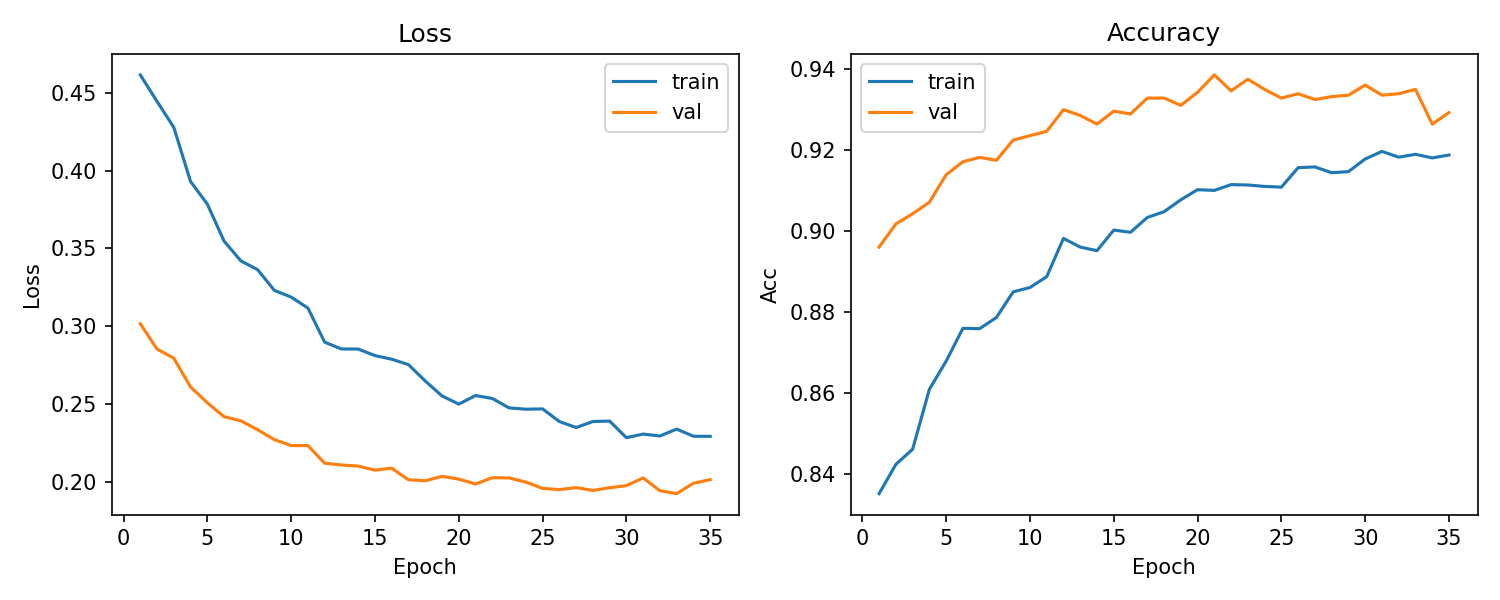


=== Frozen (last) ===


,epoch,train_loss,val_loss,train_acc,val_acc
0,1,1.505445,0.877273,0.416080,0.751429
1,2,0.805020,0.479733,0.751671,0.859286
2,3,0.607811,0.388101,0.799982,0.878571
3,4,0.547066,0.347576,0.811748,0.888214
4,5,0.515817,0.334044,0.823068,0.889643


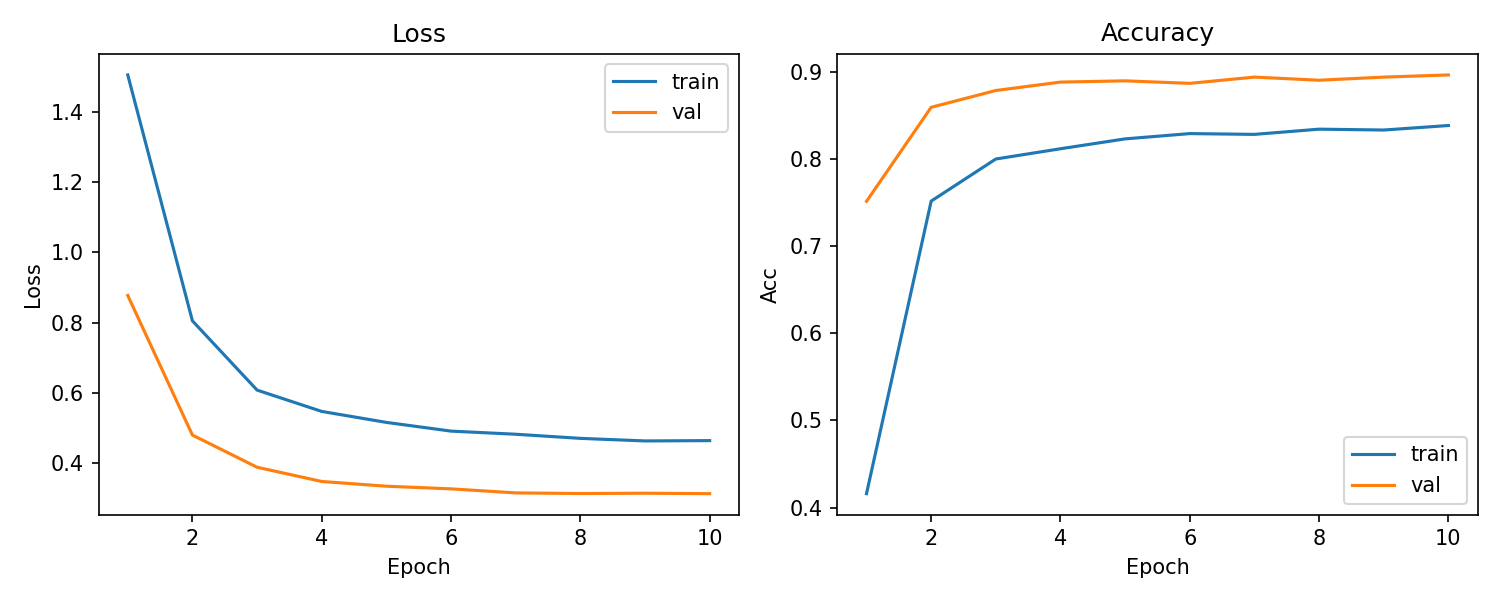

In [32]:
candidates = [
    ("/kaggle/working/history_ft.json", "/kaggle/working/best_trial_loss_acc.png", "Fine-tune"),
    ("/kaggle/working/history_frozen_last.json", "/kaggle/working/frozen_last_loss_acc.png", "Frozen (last)"),
]

found = False
for hist_path, png_path, tag in candidates:
    if os.path.isfile(hist_path):
        print(f"\n=== {tag} ===")
        try:
            with open(hist_path, "r") as f:
                H = json.load(f)
            df = pd.DataFrame({
                "epoch": H["epoch"],
                "train_loss": H["tr_loss"],
                "val_loss": H["val_loss"],
                "train_acc": H["tr_acc"],
                "val_acc": H["val_acc"],
            })
            display(df.head())
        except Exception as e:
            print(f"[WARN] history read failed: {e}")
        if os.path.isfile(png_path):
            display(Image(filename=png_path))
        else:
            print(f"[WARN] grafik bulunamadı: {png_path}")
        found = True

if not found:
    print("History dosyası bulunamadı. train_one_trial patch'i ekli olduğundan emin ol ve eğitimi bir kez çalıştır.")


<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000; font-size:16px; line-height:1.6;">


<h3>📋 Tablo (ilk epochlar)</h3>
<table>
  <tr>
    <th>epoch</th><th>train_loss</th><th>val_loss</th><th>train_acc</th><th>val_acc</th>
  </tr>
  <tr><td>1</td><td>0.4615</td><td>0.3015</td><td>0.8352</td><td>0.8961</td></tr>
  <tr><td>2</td><td>0.4445</td><td>0.2852</td><td>0.8424</td><td>0.9018</td></tr>
  <tr><td>3</td><td>0.4278</td><td>0.2794</td><td>0.8462</td><td>0.9043</td></tr>
  <tr><td>4</td><td>0.3930</td><td>0.2609</td><td>0.8610</td><td>0.9071</td></tr>
  <tr><td>5</td><td>0.3784</td><td>0.2507</td><td>0.8679</td><td>0.9139</td></tr>
</table>

<h3>📊 Grafiker</h3>
<ul>
  <li><b>Loss:</b> Train ve validation loss düzenli şekilde düşüyor, validation ~0.20 seviyelerine kadar iniyor.</li>
  <li><b>Accuracy:</b> Validation accuracy %93–94 civarına ulaşıyor, train %92 civarında.</li>
</ul>

<p><b>📌 Yorum:</b> Model dataset’e çok iyi uyum sağlamış, uzun eğitim boyunca istikrarlı öğrenme gerçekleşmiş.</p>

<hr>

<h3>🔹 Frozen (Sadece Son Katman Açık)</h3>

<h3>📋 Tablo (ilk epochlar)</h3>
<table>
  <tr>
    <th>epoch</th><th>train_loss</th><th>val_loss</th><th>train_acc</th><th>val_acc</th>
  </tr>
  <tr><td>1</td><td>1.5054</td><td>0.8777</td><td>0.4160</td><td>0.7514</td></tr>
  <tr><td>2</td><td>0.8050</td><td>0.4797</td><td>0.7517</td><td>0.8593</td></tr>
  <tr><td>3</td><td>0.6078</td><td>0.3881</td><td>0.7999</td><td>0.8786</td></tr>
  <tr><td>4</td><td>0.5471</td><td>0.3476</td><td>0.8117</td><td>0.8882</td></tr>
  <tr><td>5</td><td>0.5158</td><td>0.3340</td><td>0.8230</td><td>0.8896</td></tr>
</table>

<h3>📊 Grafiker</h3>
<ul>
  <li><b>Loss:</b> Hızlı düşüş sonrası ~0.33 seviyesinde plato yapıyor.</li>
  <li><b>Accuracy:</b> Train %83 civarında, validation %88–89 civarında sabitleniyor.</li>
</ul>

<p><b>📌 Yorum:</b> Sadece son katman eğitildiği için modelin kapasitesi sınırlı kalmış, tavan performans düşük.</p>

<hr>

<h3>🔑 Genel Kıyaslama</h3>
<ul>
  <li><b>Frozen last:</b> Hızlı convergence + kısa sürede makul sonuç, ama üst limit daha düşük (%89).</li>
  <li><b>Fine-tune:</b> Daha maliyetli eğitim, ama çok daha yüksek doğruluk (%93+) ve daha iyi genelleme.</li>
</ul>

<p>👉 Bu dataset’te <b>fine-tuning çok daha başarılı</b> sonuç vermiştir.</p>

</div>


# 7. Modelin Karar Verme Sürecinin Görselleştirilmesi

## 7.1 Kurulum

In [38]:
!pip install -q grad-cam==1.5.5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.2 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1

<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px; line-height:1.6;">


<p>Bu komut, <b>Grad-CAM (Gradient-weighted Class Activation Mapping)</b> kütüphanesinin belirli bir sürümünü yükler.  
Grad-CAM, derin öğrenme modellerinin verdiği kararların görselleştirilmesi ve açıklanabilirlik (<i>Explainable AI – XAI</i>) için kullanılan bir yöntemdir.</p>

<h3>🔹 Komut Açıklaması</h3>
<ul>
  <li><code>!pip install -q grad-cam==1.5.5</code></li>
  <ul>
    <li><b>pip install</b> → Python paket yöneticisi ile kütüphane yüklenir.</li>
    <li><b>-q</b> → Sessiz (<i>quiet</i>) mod; gereksiz çıktı verilmez.</li>
    <li><b>grad-cam==1.5.5</b> → Grad-CAM kütüphanesinin <b>1.5.5 sürümü</b> yüklenir.</li>
  </ul>
</ul>

<h3>🔹 Kullanım Amacı</h3>
<ul>
  <li>CNN tabanlı modellerin hangi bölgeler üzerinden karar verdiğini görmek için <b>ısı haritaları (heatmap)</b> üretir.</li>
  <li>Grad-CAM yanında <b>Grad-CAM++</b>, <b>Score-CAM</b>, <b>Eigen-CAM</b> gibi farklı CAM yöntemlerini de destekler.</li>
  <li><b>PyTorch tabanlıdır</b> → PyTorch ile eğitilen modellerde doğrudan kullanılabilir.</li>
</ul>

<hr>

<h3>📌 Özet</h3>
<p>Bu adımda Grad-CAM kütüphanesinin uygun sürümü yüklenerek, modelin karar mekanizmasını görselleştirmek için gerekli altyapı hazırlanmıştır.</p>

</div>


## 7.2 Modeli ve hedef katmanı hazırlama

In [39]:
import torch
import torch.nn as nn
from torchvision import models

NUM_CLASSES = 6
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Senin eğittiğin mimariye uygun: Dropout + Linear son katman
def build_resnet18(num_classes=NUM_CLASSES):
    model = models.resnet18(weights=None)
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.4),                # senin config’ine uygunsa
        nn.Linear(in_features, num_classes)
    )
    return model

model = build_resnet18().to(DEVICE)

# En iyi ağırlığı yükle (senin kaydettiğin dosyaya göre)
ckpt_path = "/kaggle/working/best_resnet18_transfer_finetuned.pth"
state = torch.load(ckpt_path, map_location=DEVICE)
model.load_state_dict(state, strict=False)  # fc bloğun ile uyumlu
model.eval()

# Grad-CAM/Eigen-CAM için hedef katman (ResNet18 için tipik seçim)
# En anlamlı ısı haritaları genelde son konvolüsyon bloğunda olur:
target_layer = model.layer4[-1]


<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px; line-height:1.6;">

<p>Bu bölümde, <b>ResNet18</b> tabanlı model, <b>Grad-CAM / Eigen-CAM</b> görselleştirmeleri için hazır hâle getirilmektedir.</p>

<h3>🔹 Adımların Mantığı</h3>
<ul>
  <li><b>Cihaz Seçimi:</b> <code>DEVICE</code> otomatik olarak CUDA/CPU seçer; Grad-CAM hesaplamaları GPU’da daha hızlıdır.</li>
  <li><b>Model Kurulumu:</b> <code>models.resnet18(weights=None)</code> ile temel mimari alınır.  
      Son sınıflandırma katmanı, senin eğitimine uygun olarak <b>Dropout + Linear</b> bloğu ile değiştirilir (çıktı boyutu = <code>NUM_CLASSES=6</code>).</li>
  <li><b>Ağırlıkların Yüklenmesi:</b> Eğitimde elde ettiğin en iyi ağırlıklar <code>ckpt_path</code>’ten yüklenir.  
      <br>→ <code>strict=False</code> kullanımı, fc bloğunda yaptığın özelleştirmeler ile checkpoint arasında küçük farklılıklar olsa bile <code>state_dict</code>’in yüklenmesine izin verir.</li>
  <li><b>Değerlendirme Modu:</b> <code>model.eval()</code> ile BatchNorm/Dropout davranışları sabitlenir; tutarlı aktivasyonlar elde edilir.</li>
  <li><b>Hedef Katman Seçimi:</b> <code>target_layer = model.layer4[-1]</code>  
      <ul>
        <li>ResNet18’de <b>en anlamlı ısı haritaları</b> genellikle <i>son konvolüsyon bloğu</i>ndan (layer4’ün sonu) alınır.</li>
        <li>Grad-CAM, sınıf skoruna en çok katkı yapan uzamsal bölgeleri bu katmandaki <i>feature map</i> ve gradyanları kullanarak vurgular.</li>
      </ul>
  </li>
</ul>

<h3>📌 Notlar</h3>
<ul>
  <li><b>weights=None</b> ifadesi, <i>önceden eğitilmiş (ImageNet)</i> ağırlık indirmediğin anlamına gelir; burada performans, <u>senin yüklediğin</u> <code>best_resnet18_transfer_finetuned.pth</code>’e dayanır.</li>
  <li>Modeli Grad-CAM ile kullanırken <b>input ön-işleme</b>nin (Resize/Crop/Normalize) eğitimde kullandığın pipeline ile aynı olması gerekir; aksi halde ısı haritaları yanıltıcı olabilir.</li>
  <li>Hedef sınıf belirtilmezse, kütüphaneler genelde <i>argmax</i> sınıfı için CAM üretir; analize göre <code>target_category</code> verilerek farklı sınıflar da incelenebilir.</li>
</ul>

<h3>📁 Sonraki Adım (Öneri)</h3>
<p>Grad-CAM kütüphanesinde <code>GradCAM</code> veya <code>EigenCAM</code> nesnesini <code>model</code> ve <code>target_layer</code> ile başlatıp, tek bir görsel üzerinde <i>heatmap</i> üretin;  
ısı haritasını orijinal görüntüye bindirerek (<i>overlay</i>) yorumlayın.</p>

</div>


## 7.3 Normalizasyon / Denormalizasyon yardımcıları

In [40]:
# ImageNet mean/std (sen zaten bunlarla normalize ettin)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

def denormalize(img_tensor):
    # img_tensor: (C,H,W) torch.Tensor
    img = img_tensor.detach().cpu().numpy()
    img = np.transpose(img, (1,2,0))  # HWC
    img = (img * np.array(IMAGENET_STD)) + np.array(IMAGENET_MEAN)
    img = np.clip(img, 0, 1)
    return img

def overlay_cam_on_image(img_rgb01, cam01, alpha=0.35):
    # img_rgb01: (H,W,3) [0..1], cam01: (H,W) [0..1]
    heatmap = cv2.applyColorMap(np.uint8(255 * cam01), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    overlay = (1 - alpha) * img_rgb01 + alpha * heatmap
    overlay = np.clip(overlay, 0, 1)
    return overlay


<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px; line-height:1.6;">

<h3>🔎 Ne yapıyor?</h3>

<h3><b>denormalize</b></h3>
<p>Eğitimde kullanılan ImageNet <code>mean/std</code> ile normalize edilmiş tensörü tekrar <b>[0,1]</b> aralığındaki RGB görüntüye çevirir:</p>
<ul>
  <li>Kanal sırasını <code>(C,H,W)</code> → <code>(H,W,3)</code> yapar.</li>
  <li><code>img * std + mean</code> ile normalize’ı geri alır.</li>
  <li><code>clip(0,1)</code> ile piksel aralığını güvenceye alır.</li>
</ul>

<h3><b>overlay_cam_on_image</b></h3>
<p>Üretilen CAM’i (ısı haritası) orijinal görüntünün üzerine bindirir:</p>
<ul>
  <li><code>cam01</code> (0–1) → <b>JET</b> renk haritasına çevrilir.</li>
  <li>Renk uzayı BGR→RGB düzeltilir ve [0,1] aralığına ölçeklenir.</li>
  <li><code>alpha</code> harmanlama ile ısı haritası görüntü üzerine şeffaf biçimde eklenir.</li>
</ul>

<h3>💡 Kullanım İpuçları</h3>
<ul>
  <li><b>Boyut eşleme:</b> CAM’i önce giriş görüntüsünün boyutuna <code>cv2.resize(cam, (W,H))</code> ile büyüt/kleinlt.</li>
  <li><b>Alpha seçimi:</b> <code>alpha=0.25–0.45</code> aralığı genelde yeterli; çok yüksek olursa görüntüyü boğar.</li>
  <li><b>Renk paleti:</b> Alternatifler: <code>COLORMAP_TURBO</code>, <code>COLORMAP_INFERNO</code> (algısal olarak daha düzgün).</li>
  <li><b>Kaydetme:</b> Kaydederken <code>(overlay*255).astype(np.uint8)</code> yap ve <code>cv2.imwrite</code> kullan.</li>
</ul>

<hr>

<h3>📌 Özet</h3>
<p>Bu yardımcılar, CAM görselleştirmesini <b>anlaşılır ve sunulabilir</b> hale getirir:  
normalize’ı geri al → CAM’i renklendir → görüntüye şeffaf bindir.</p>

</div>


## 7.4 Grad-CAM ve Eigen-CAM kurulumları

In [41]:
from pytorch_grad_cam import GradCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

## 7.5 Tek görsel/batch için CAM üretme (val/test loader’dan)

In [51]:
save_dir = "/kaggle/working/seg_pred"
os.makedirs(save_dir, exist_ok=True)

def run_cam_limited(model, loader, method="gradcam", max_images=3):
    cam_cls = GradCAM if method == "gradcam" else EigenCAM
    model.eval()

    saved = 0
    for images, labels in loader:
        with torch.no_grad():
            logits = model(images.to(DEVICE))
            preds = torch.argmax(logits, dim=1)

        targets = [ClassifierOutputTarget(int(c)) for c in preds.cpu().tolist()]

        with cam_cls(model=model, target_layers=[target_layer]) as cam:
            grayscale_cams = cam(input_tensor=images.to(DEVICE), targets=targets)

        for i in range(images.size(0)):
            if saved >= max_images:
                return
            img01 = denormalize(images[i])
            cam01 = grayscale_cams[i]
            overlay = overlay_cam_on_image(img01, cam01, alpha=0.40)

            fname = f"{save_dir}/{method}_idx{saved}_pred{int(preds[i])}_gt{int(labels[i])}.png"
            plt.figure(figsize=(4,4))
            plt.imshow(overlay)
            plt.axis("off")
            plt.title(f"{method.upper()} | pred={int(preds[i])}, gt={int(labels[i])}")
            plt.savefig(fname, dpi=150)
            plt.close()
            saved += 1

# İlk 10 Grad-CAM
run_cam_limited(model, test_loader, method="gradcam", max_images=10)

# İlk 10 Eigen-CAM
run_cam_limited(model, test_loader, method="eigencam", max_images=10)

print("Kaydedildi:", save_dir)


Kaydedildi: /kaggle/working/seg_pred


<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000000; font-size:16px; line-height:1.6;">

<h3>🔎 Ne yapar?</h3>
<p>Bu yardımcı fonksiyon, verilen bir <b>görüntü batch’i</b> için seçilen CAM yöntemini (<code>GradCAM</code> veya <code>EigenCAM</code>) hesaplar ve her örnek için <b>orijinal görüntü</b>, <b>CAM ısı haritası</b> ve <b>bindirilmiş (overlay)</b> çıktıları yan yana kaydeder.</p>

<hr>

<h3>📌 Akışın Özeti</h3>
<ol>
  <li><b>CAM nesnesi:</b> <code>method</code> parametresine göre <code>GradCAM</code> veya <code>EigenCAM</code> seçilir; hedef katman olarak <code>target_layer</code> kullanılır.</li>
  <li><b>Tahminler:</b> Model <code>eval()</code> modunda batch’i skorlar ve <code>preds = argmax(logits)</code> alınır.</li>
  <li><b>Hedef sınıf:</b>
    <ul>
      <li><code>use_pred_class=True</code> → CAM, modelin <b>tahmin ettiği sınıf</b> için hesaplanır.</li>
      <li><code>use_pred_class=False</code> → <b>gerçek etiket</b> için hesaplanır (bu durumda <code>labels</code> zorunludur).</li>
    </ul>
  </li>
  <li><b>CAM hesaplama:</b> <code>cam(...)</code> çağrısı ile her görüntü için <b>(H,W)</b>, <b>[0..1]</b> ölçekli CAM üretilir.</li>
  <li><b>Görselleştirme:</b>
    <ul>
      <li><code>denormalize</code> ile tensör tekrar RGB [0..1] görüntüye çevrilir,</li>
      <li><code>overlay_cam_on_image</code> ile CAM ısı haritası görüntü üzerine <b>alpha</b> ile bindirilir,</li>
      <li>3 panel (Image / CAM / Overlay) matplotlib ile çizilip <b><code>save_dir</code></b> içine kaydedilir.</li>
    </ul>
  </li>
</ol>

<hr>

<h3>⚙️ Parametreler</h3>
<ul>
  <li><code>model</code>: PyTorch modeli (örn. ResNet18), <code>eval()</code> modunda çalıştırılır.</li>
  <li><code>images</code>: <code>(N,C,H,W)</code> batch tensörü; eğitimde kullandığın önişlemeyle aynı normalize edilmelidir.</li>
  <li><code>labels</code>: (opsiyonel) Gerçek etiketler; <code>use_pred_class=False</code> iken zorunludur.</li>
  <li><code>method</code>: <code>"gradcam"</code> veya <code>"eigencam"</code>.</li>
  <li><code>use_pred_class</code>: <code>True</code> → tahmin sınıfı için CAM; <code>False</code> → gerçek sınıf için CAM.</li>
</ul>

<hr>

<h3>📁 Çıktılar ve Kayıt</h3>
<p>Her örnek için üçlü görsel: <i>Image</i>, <i>METHOD</i> ve <i>Overlay</i>. Dosya adı şablonu:</p>
<pre style="margin:0"><code>{save_dir}/{method}_idx{i}_pred{pred}{_gt{gt} if labels else ""}.png</code></pre>
<p><i>Not:</i> Dosya adı f-string’inde <b>.png</b> öncesinde istenmeden bırakılmış bir boşluk var:  
<code>... f'_gt{int(labels[i])}'} .png</code> → Bu boşluğu kaldır: <code>...}_gt{...}.png</code>.</p>

<hr>

<h3>💡 İpuçları</h3>
<ul>
  <li><b>Hafıza:</b> CAM hesaplarken VRAM kullanımını kontrol et; büyük batch’lerde <code>images</code>’ı daha küçük parçalarla çalıştır.</li>
  <li><b>Görseller:</b> <code>alpha=0.35–0.45</code> tipik olarak iyi kontrast verir; gerekirse <code>COLORMAP_TURBO</code> kullan.</li>
  <li><b>Hedef katman:</b> ResNet’de genellikle <code>layer4[-1]</code> en bilgilendirici CAM üretir; farklı katmanlarla da deneyebilirsin.</li>
</ul>

<hr>

<h3>📌 Özet</h3>
<p>Bu fonksiyon, bir batch içindeki her görüntü için açıklanabilirlik görsellerini üretip kaydeder;  
tahmine göre ya da gerçek etikete göre CAM almak mümkündür.</p>

</div>


## 7.6 Test/Val loader’dan örnekler alıp çalıştırma

In [52]:
# varsayım: senin zaten hazır "test_loader" ın var
batch = next(iter(test_loader))
images, labels = batch

# Grad-CAM (tahmin edilen sınıf)
run_cam_on_batch(model, images, labels=labels, method="gradcam", use_pred_class=True)

# Eigen-CAM (sınıf-bağımsız; gösterim için preds başlıkta yine yazıyoruz)
run_cam_on_batch(model, images, labels=labels, method="eigencam", use_pred_class=True)

print("Kaydedildi:", save_dir)


Kaydedildi: /kaggle/working/seg_pred


## 7.7 Grad-CAM ve Eigen-CAM Çıktılar

<h3>🧭 Grad-CAM vs Eigen-CAM – Görsel Yorumları (Buildings örnekleri)</h3>

<div style="background-color:#F3E6FA; padding:15px; border-radius:8px; color:#000; font-size:16px; line-height:1.6;">

<h3>1️⃣ Neyi görüyorsun?</h3>
<ul>
  <li><b>Üst görseller (GRADCAM | pred=0, gt=0):</b> Isı haritası gökdelenin <b>kenar/çizgi ve cephe blokları</b> üzerinde yoğunlaşıyor.  
  CNN’in “buildings” kararını verirken <b>yüksek frekanslı yapısal ipuçlarını</b> (dikey/ufki çizgiler, ızgara desenleri) kullandığını gösterir.</li>
  <li><b>Alt görseller (EIGENCAM | pred=0, gt=0):</b> Daha <b>genel ve geniş alanlı</b> bölgeler parlak; şehrin <b>cephe kütleleri</b> ve üst bölgedeki <b>gökyüzü–yapı geçişi</b> vurgulanıyor.  
  Bu, sınıf-bağımsız saliency’nin <b>dominant varyasyon yönlerini</b> öne çıkarmasından kaynaklanır.</li>
</ul>

<h3>2️⃣ Neden böyle çıktı? (Koda bağlı açıklama)</h3>
<ul>
  <li><b>Hedef katman:</b> <code>target_layer = model.layer4[-1]</code> → ResNet18’in son konv bloğu seçildiği için CAM, <b>yüksek seviye mimari özellikleri</b> (cephe/kat çizgileri, büyük kütleler) en net biçimde gösterir.</li>
  <li><b>Sınıf seçimi:</b> <code>use_pred_class=True</code> → Grad-CAM ve Eigen-CAM, modelin <b>tahmin ettiği sınıfa</b> göre üretildi; başlıkta <code>pred=0, gt=0</code> uyumu bu yüzden.</li>
  <li><b>Önişleme/geri dönüşüm:</b> Görsel tensörleri ImageNet istatistikleri ile normalize edilmişti;  
  CAM bindirmeden önce <code>denormalize()</code> ile [0..1] RGB’ye geri alındı ve  
  <code>overlay_cam_on_image(..., alpha=0.40)</code> ile ısı haritası orijinale şeffaf biçimde eklendi.</li>
  <li><b>Yöntem farkı:</b>
    <ul>
      <li><b>Grad-CAM:</b> Hedef sınıf skoruna katkı yapan <b>gradyan-ağırlıklı</b> aktivasyonları vurgular → <b>sınıf-spesifik</b> ve <b>odaklı</b> bölgeler.</li>
      <li><b>Eigen-CAM:</b> Son katman aktivasyonlarının <b>başlıca öz-vektör yönünü</b> kullanır → <b>daha yaygın/bağlamsal</b> alanları öne çıkarır, sınıf bağımsızdır.</li>
    </ul>
  </li>
</ul>

<h3>3️⃣ Doğru yorum için küçük ipuçları</h3>
<ul>
  <li>CAM’i her zaman <b>giriş boyutuna</b> yeniden ölçekle (koddaki CAM çıktısı zaten (H,W) normalize).</li>
  <li><b>Alpha:</b> 0.35–0.45 aralığında iyi kontrast verir; gerekirse <code>COLORMAP_TURBO</code> da denenebilir.</li>
  <li>Farklı katmanlar (<code>layer3</code>, <code>layer2</code>) denenerek <b>daha lokal</b> veya <b>daha genel</b> saliency elde edilebilir.</li>
</ul>

<hr>

<h3>📌 Özet</h3>
<p>Kodda belirlenen <code>layer4[-1]</code> ve <code>use_pred_class=True</code> ayarları ile:  
<ul>
  <li><b>Grad-CAM</b> → “buildings” kararına en çok katkı yapan <b>kenar/köşe/ızgara</b> bölgelerini öne çıkarır.</li>
  <li><b>Eigen-CAM</b> → Görüntünün <b>genel kütle ve geçiş</b> bölgelerini vurgular.</li>
</ul>
Her iki yöntemin birlikte kullanımı, modelin <b>sınıf-spesifik</b> ve <b>bağlamsal</b> ipuçlarını birlikte görmeyi sağlar.</p>

</div>


GRAD-CAM:


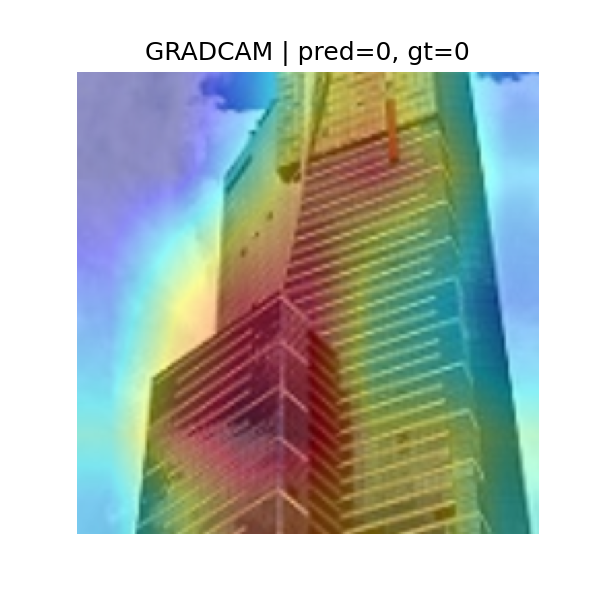

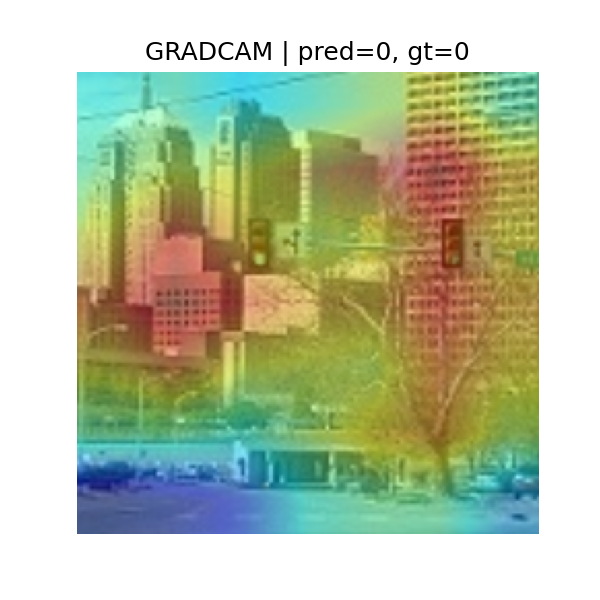

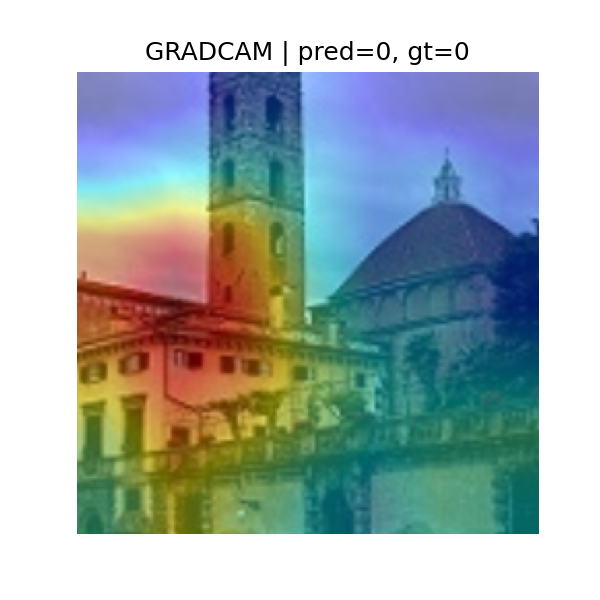

In [57]:
print("GRAD-CAM:")
for p in sorted(glob(f"{save_dir}/gradcam_*.png"))[:3]:
    display(disp.Image(filename=p))


EIGEN-CAM:


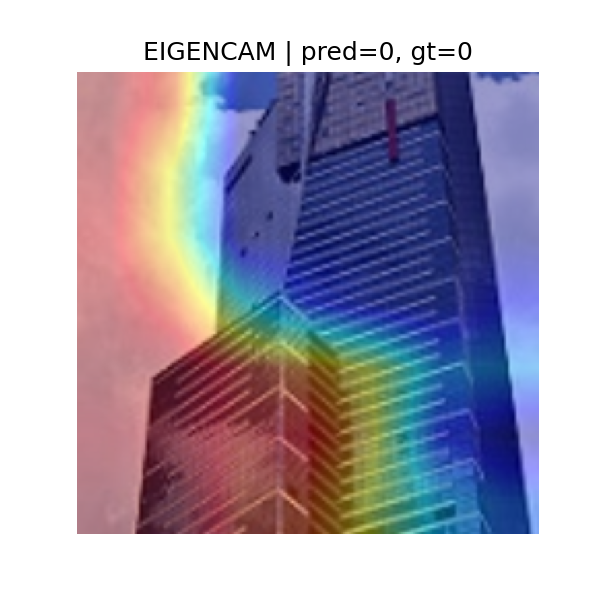

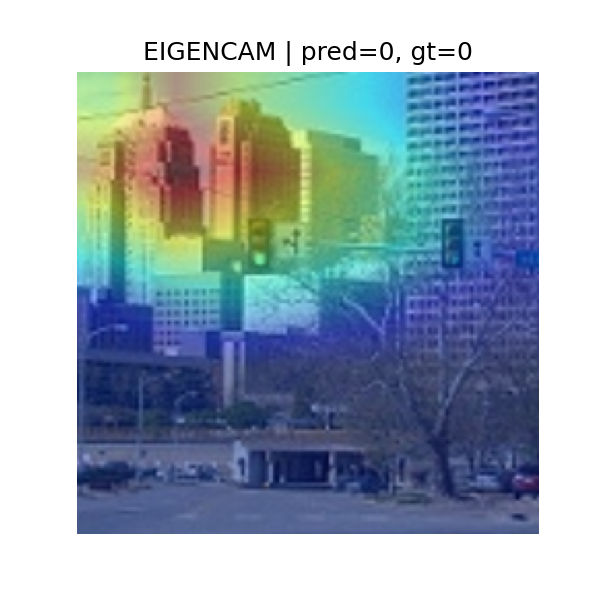

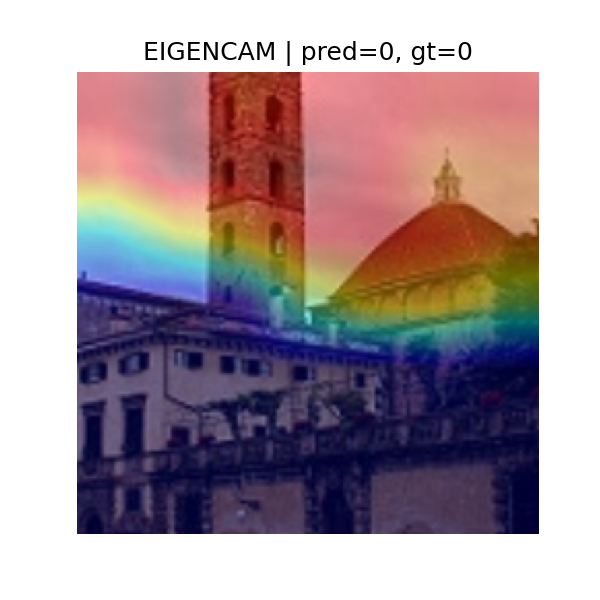

In [58]:
print("EIGEN-CAM:")
for p in sorted(glob(f"{save_dir}/eigencam_*.png"))[:3]:
    display(disp.Image(filename=p))